#### About this notebook:  This jupyter notebook is used to 1) select the FM-factors which show difference between the drug treated group and non-drug treated group,  2) cluster the FM-factor matrix into different states, and 3) annotate each state using the FM-factors. The input files are from the results of Example1-generate-FM-matrix.ipynb.

#### Load libraries

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import scipy 
import scipy.stats as ss
import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest
sys.path.append('../Script/')
import FM_States
import FM_selection
import TF
import rpy2
from rpy2.robjects.packages import importr
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

base = importr('base')
CC = importr('ConsensusClusterPlus')
pheatmap = importr('pheatmap')
bezier = importr('bezier')
ROOT_DIR = os.path.abspath("../")

#### Load parameters: Load FM-factors with drug treatment and FM-factors without drug treatment

In [2]:
para_in = {
    'input_FM_matrix_file': os.path.join(ROOT_DIR, "Sample_output/Example1/matrix_factor_mcf7.csv"),
    "input_FM_matrix_file_comp": os.path.join(ROOT_DIR, "Sample_output/Example1/ctrl_factor_mcf7.csv"),
    'out_dir': ROOT_DIR+"/Sample_output/Example1/",
}

In [3]:
ctrl_factor = pd.read_csv(para_in['input_FM_matrix_file_comp'],  header=0,index_col = 'Unnamed: 0')
matrix_factor = pd.read_csv(para_in['input_FM_matrix_file'],  header=0,index_col = 'Unnamed: 0')


#### Select the FM-factors which show difference between the drug treated group and non-drug treated group

In [14]:
Diff_factors = FM_States.Diff_comp(ctrl_factor, matrix_factor)

B = Diff_factors.values
nr,nc = B.shape
result_matrix = ro.r.matrix(B, nrow=nr, ncol=nc, dimnames = [ Diff_factors.index.values, Diff_factors.columns.values])
out_dir = para_in['out_dir']
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [15]:
%%R -i result_matrix,out_dir  -o select_modules -w 5 -h 5 --units in -r 300

plt_sizeeffect <- function(result_matrix, se, fdr){
up = result_matrix[which(result_matrix[,'SizeEffect'] > se & (result_matrix[,'-log10(FDR)']) > fdr),c('SizeEffect',"-log10(FDR)")]
down = result_matrix[which(result_matrix[,'SizeEffect'] < -1 * se & (result_matrix[,'-log10(FDR)']) > fdr),c('SizeEffect',"-log10(FDR)")]
select_modules = c(rownames(up), rownames(down))
select_matrix = rbind(up,down)
rownames(select_matrix) = select_modules
write.csv(select_matrix, file = paste(out_dir,"select_modules.csv",sep = ''))
    

    
pdf(paste(out_dir,"Fig1_sizeEffect_label.pdf",sep = ''),width = 6, height = 6)
plot(result_matrix[,c('SizeEffect',"-log10(FDR)")])
points(down, xlim = c(-12,15), pch = 20, col = "blue")
points(up, xlim = c(-12,15), pch = 20, col = "red")
text(down[,1],down[,2],rownames(down),col = "blue",pos = 1,cex = 0.3)
text(up[,1],up[,2],rownames(up),col = "red",pos = 1,cex = 0.3)
abline(h = fdr, col = "gray60",lty=2)
abline(v = se, col = "gray60",lty=2)
abline(v = -1 * se,col = "gray60",lty=2)
dev.off()


pdf(paste(out_dir,"Fig1_sizeEffect_nolabel.pdf",sep = ''),width = 6, height = 6)
plot(result_matrix[,c('SizeEffect',"-log10(FDR)")])
points(down, xlim = c(-12,15), pch = 20, col = "blue")
points(up, xlim = c(-12,15), pch = 20, col = "red")
abline(h = fdr, col = "gray60",lty=2)
abline(v = se, col = "gray60",lty=2)
abline(v = -1 * se,col = "gray60",lty=2)
dev.off()
return(select_modules)
}

select_modules = plt_sizeeffect(result_matrix, 0.2, 6) ##The selection of P value and effect size might be artificial
print(select_modules)

 [1] "Signal transduction_up"                     
 [2] "Amino acid metabolism_up"                   
 [3] "Carbohydrate metabolism_up"                 
 [4] "Membrane transport_up"                      
 [5] "Cellular community - eukaryotes_up"         
 [6] "Metabolism of other amino acids_up"         
 [7] "Signaling molecules and interaction_up"     
 [8] "Transport and catabolism_up"                
 [9] "Cell motility_up"                           
[10] "Apoptosis_up"                               
[11] "Cellular senescence_up"                     
[12] "p53 signaling pathway_up"                   
[13] "Membrane transport_down"                    
[14] "Signaling molecules and interaction_down"   
[15] "Cellular community - eukaryotes_ssGSEA"     
[16] "Membrane transport_ssGSEA"                  
[17] "Signal transduction_ssGSEA"                 
[18] "Signaling molecules and interaction_ssGSEA" 
[19] "Transport and catabolism_ssGSEA"            
[20] "Signal transduction_tf"  

#### Normalize the FM-factors with drug treatment using the distribution of FM-factors without drug treatment

In [16]:
reference_factor_select_modules = FM_States.compare_factors_between_experimental_to_reference(ctrl_factor[list(select_modules)], matrix_factor[list(select_modules)])

matrix_factor_selected = reference_factor_select_modules.loc[:,list(select_modules)]
B = matrix_factor_selected.values
nr,nc = B.shape
samples_name = ro.r.c(matrix_factor_selected.index.values)
factor_name  = ro.r.c(matrix_factor_selected.columns.values)

Br = ro.r.matrix(B, nrow=nr, ncol=nc, dimnames = [ matrix_factor_selected.index.values, matrix_factor_selected.columns.values])
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


####  Cluster the FM-factor matrix into different states using Consensus Clustering method

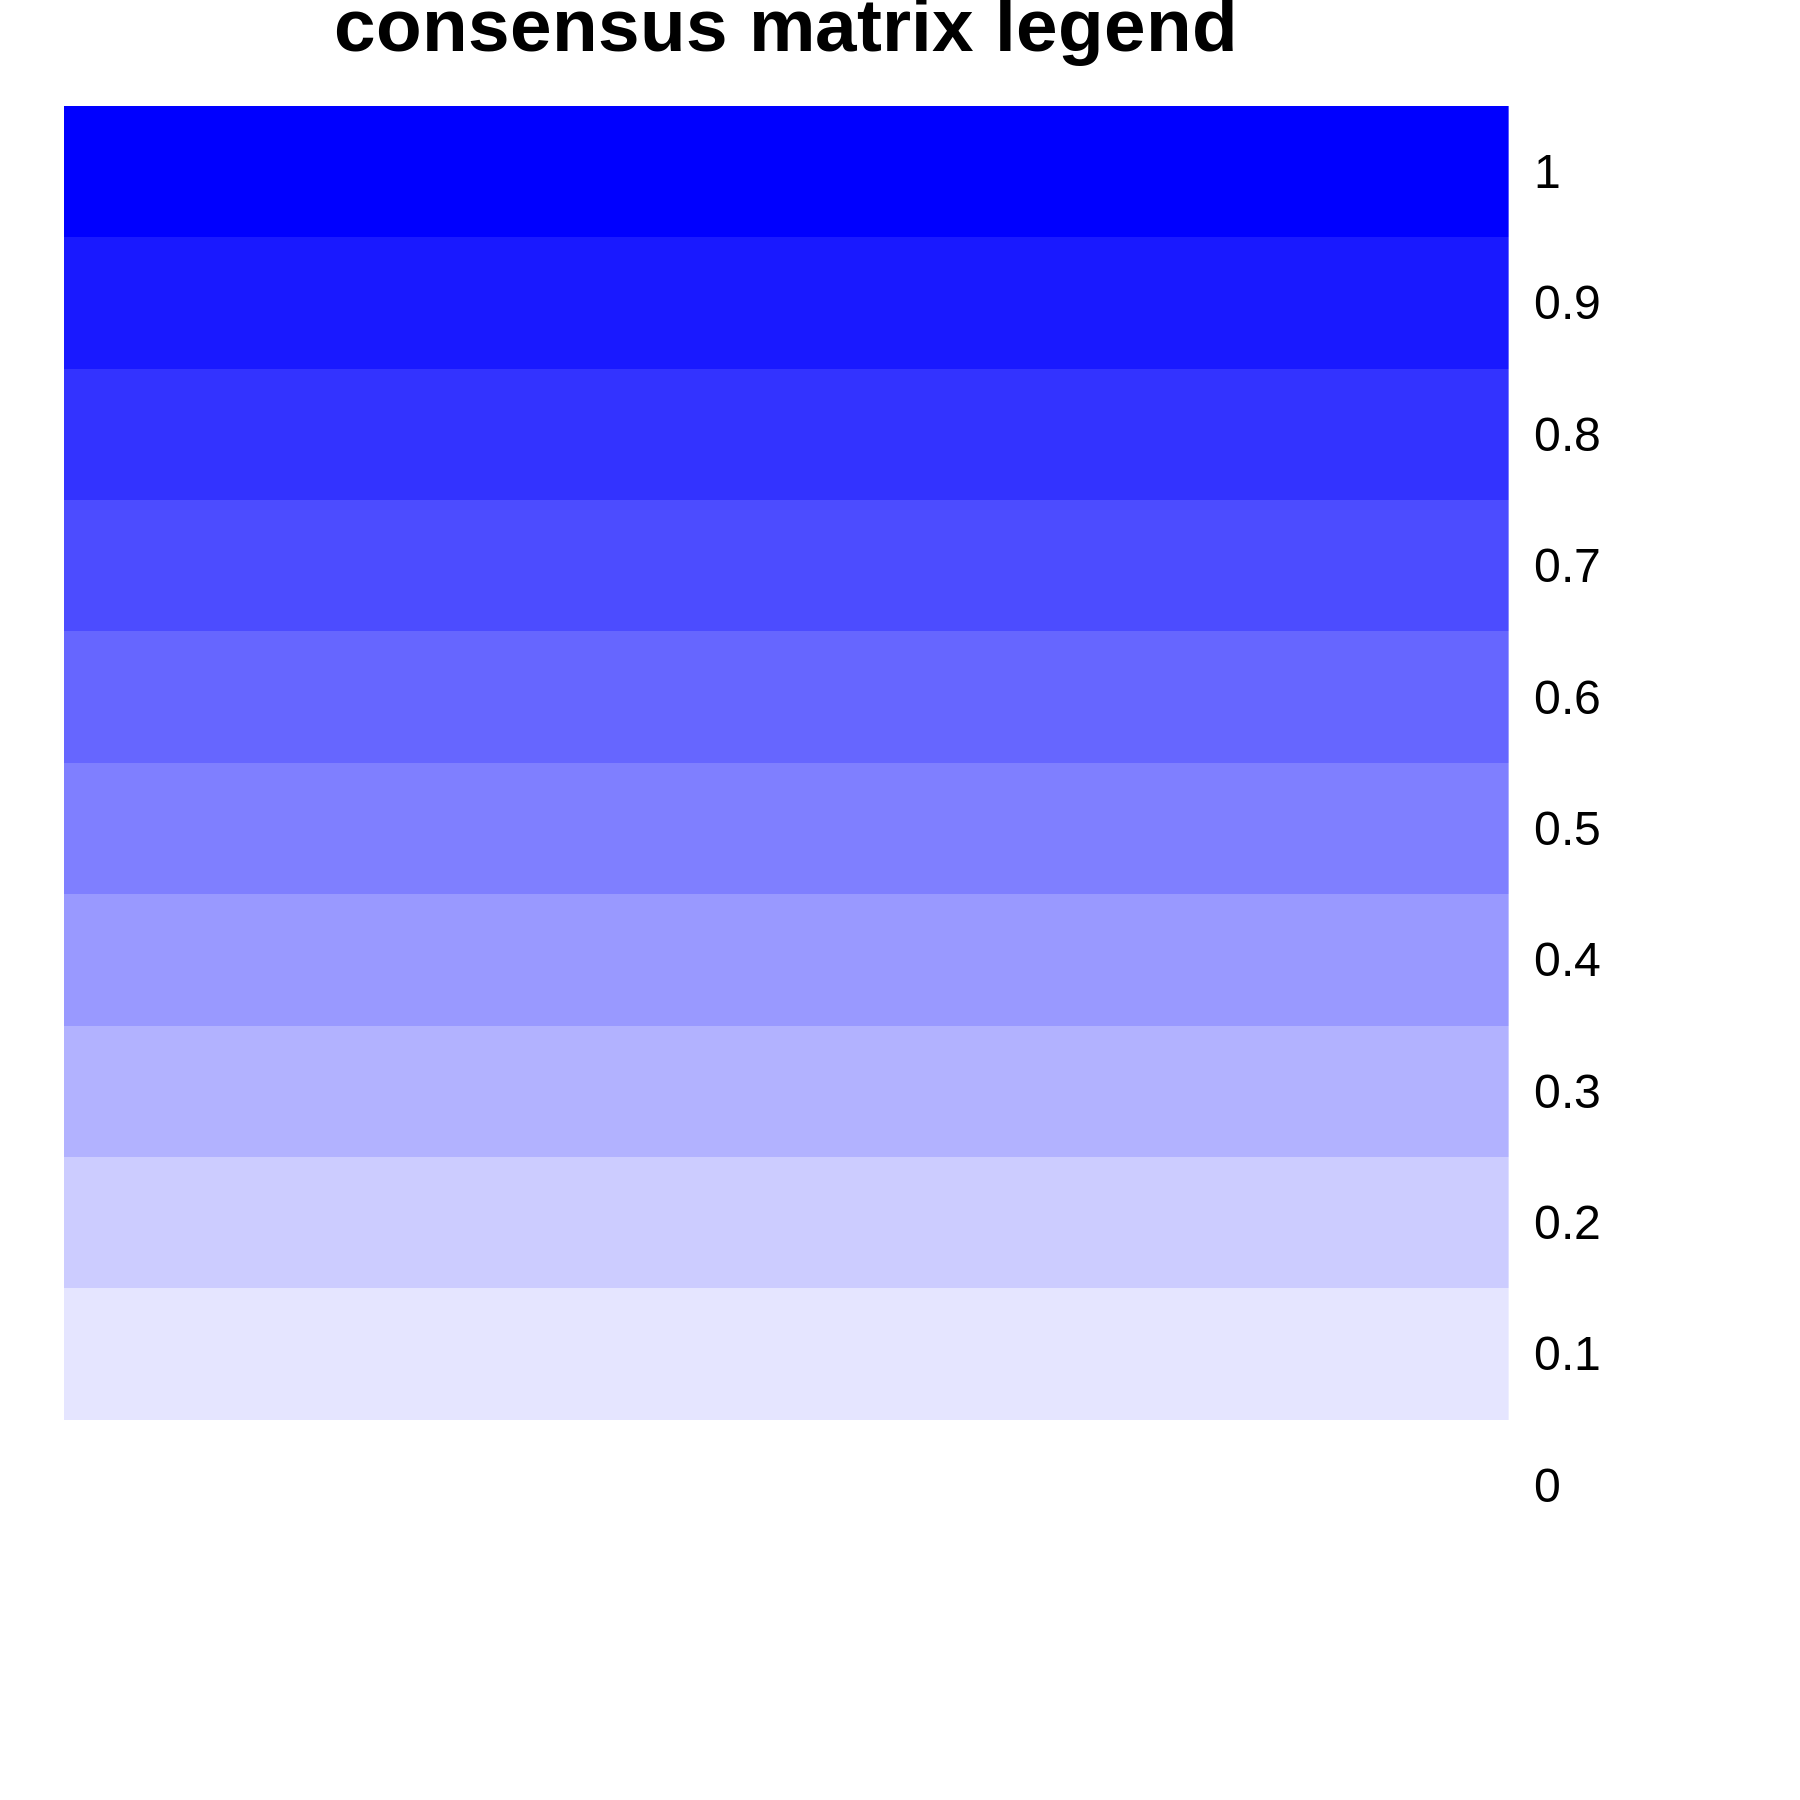

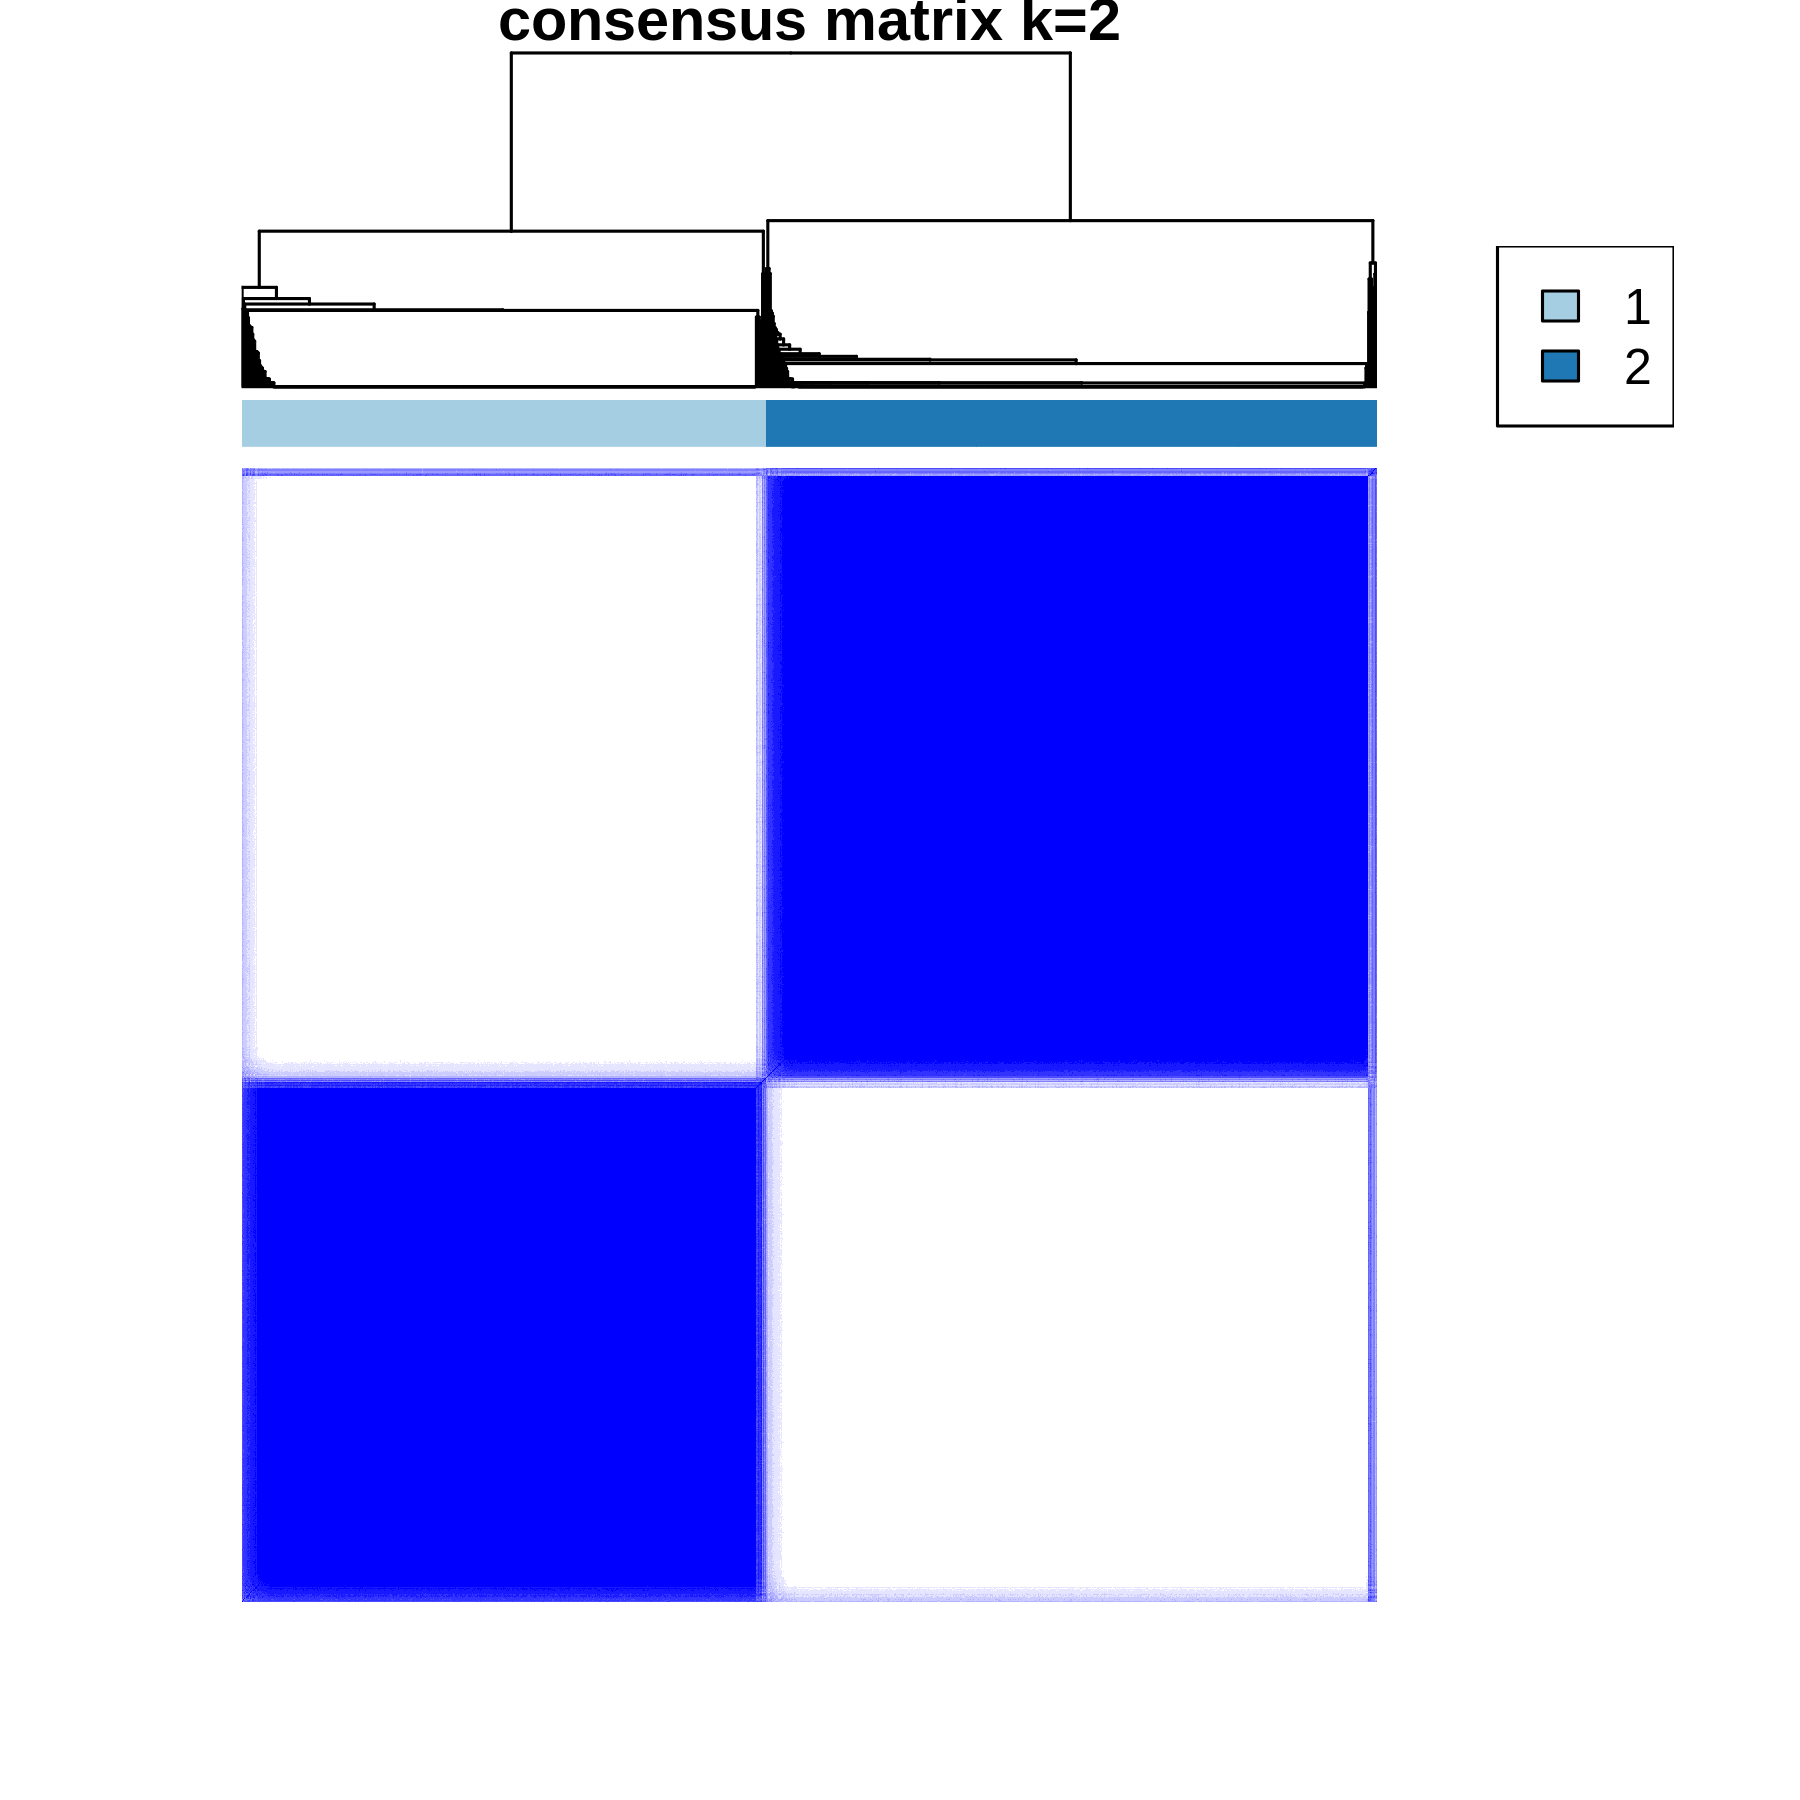

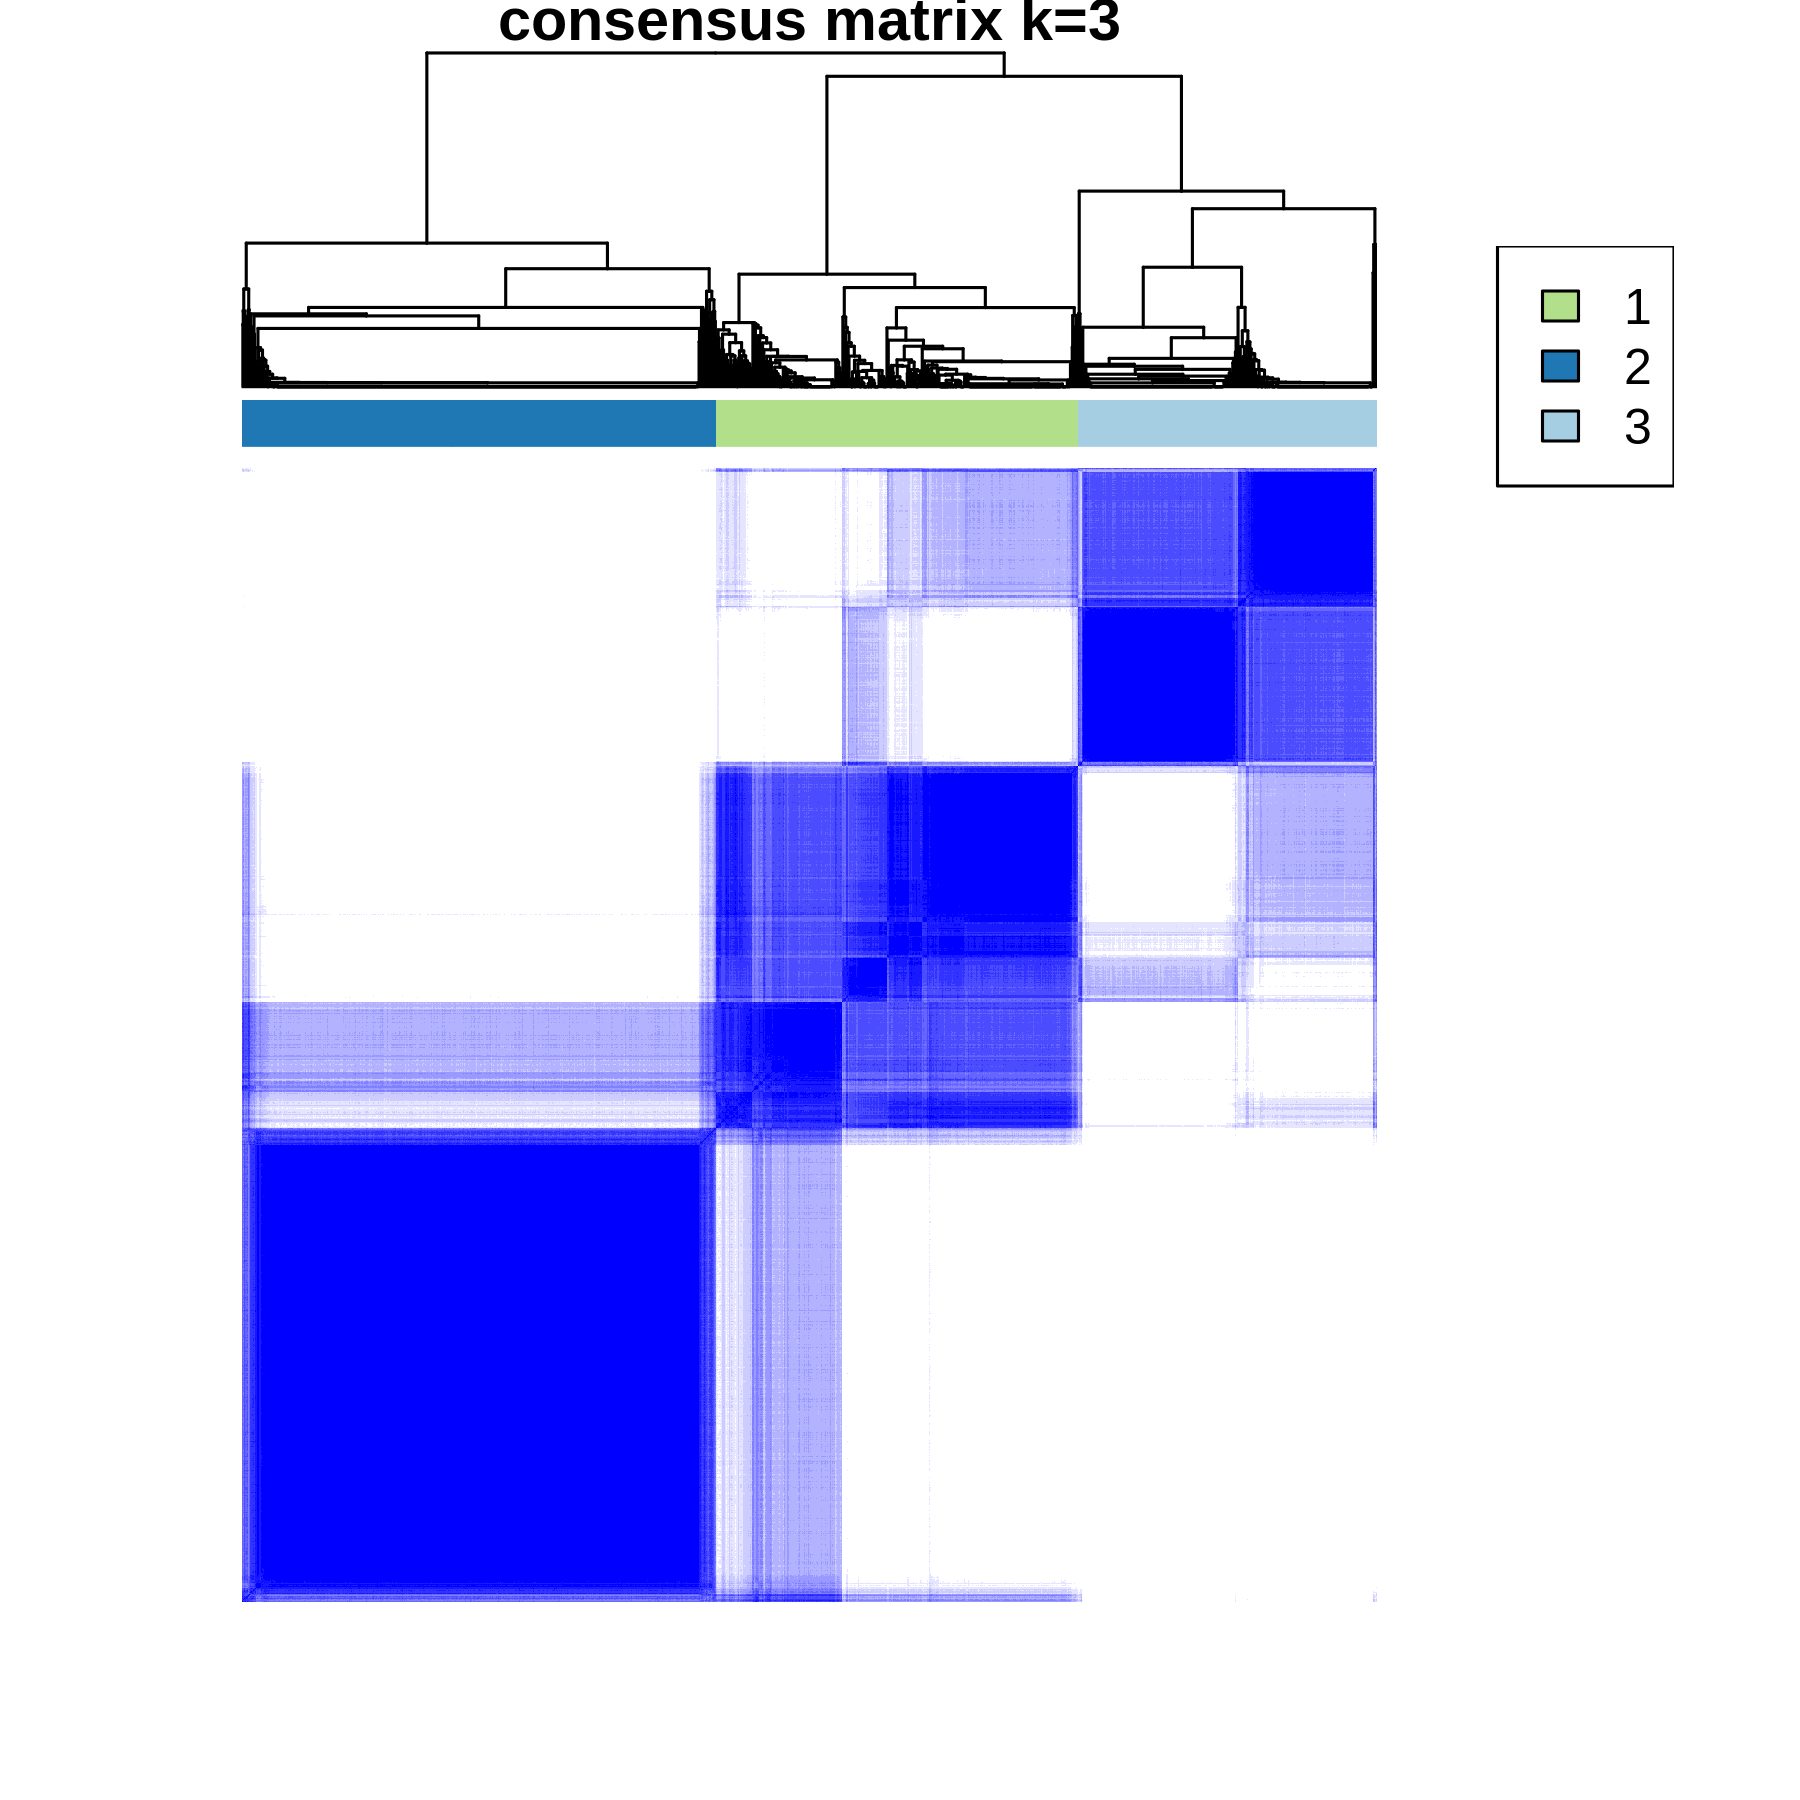

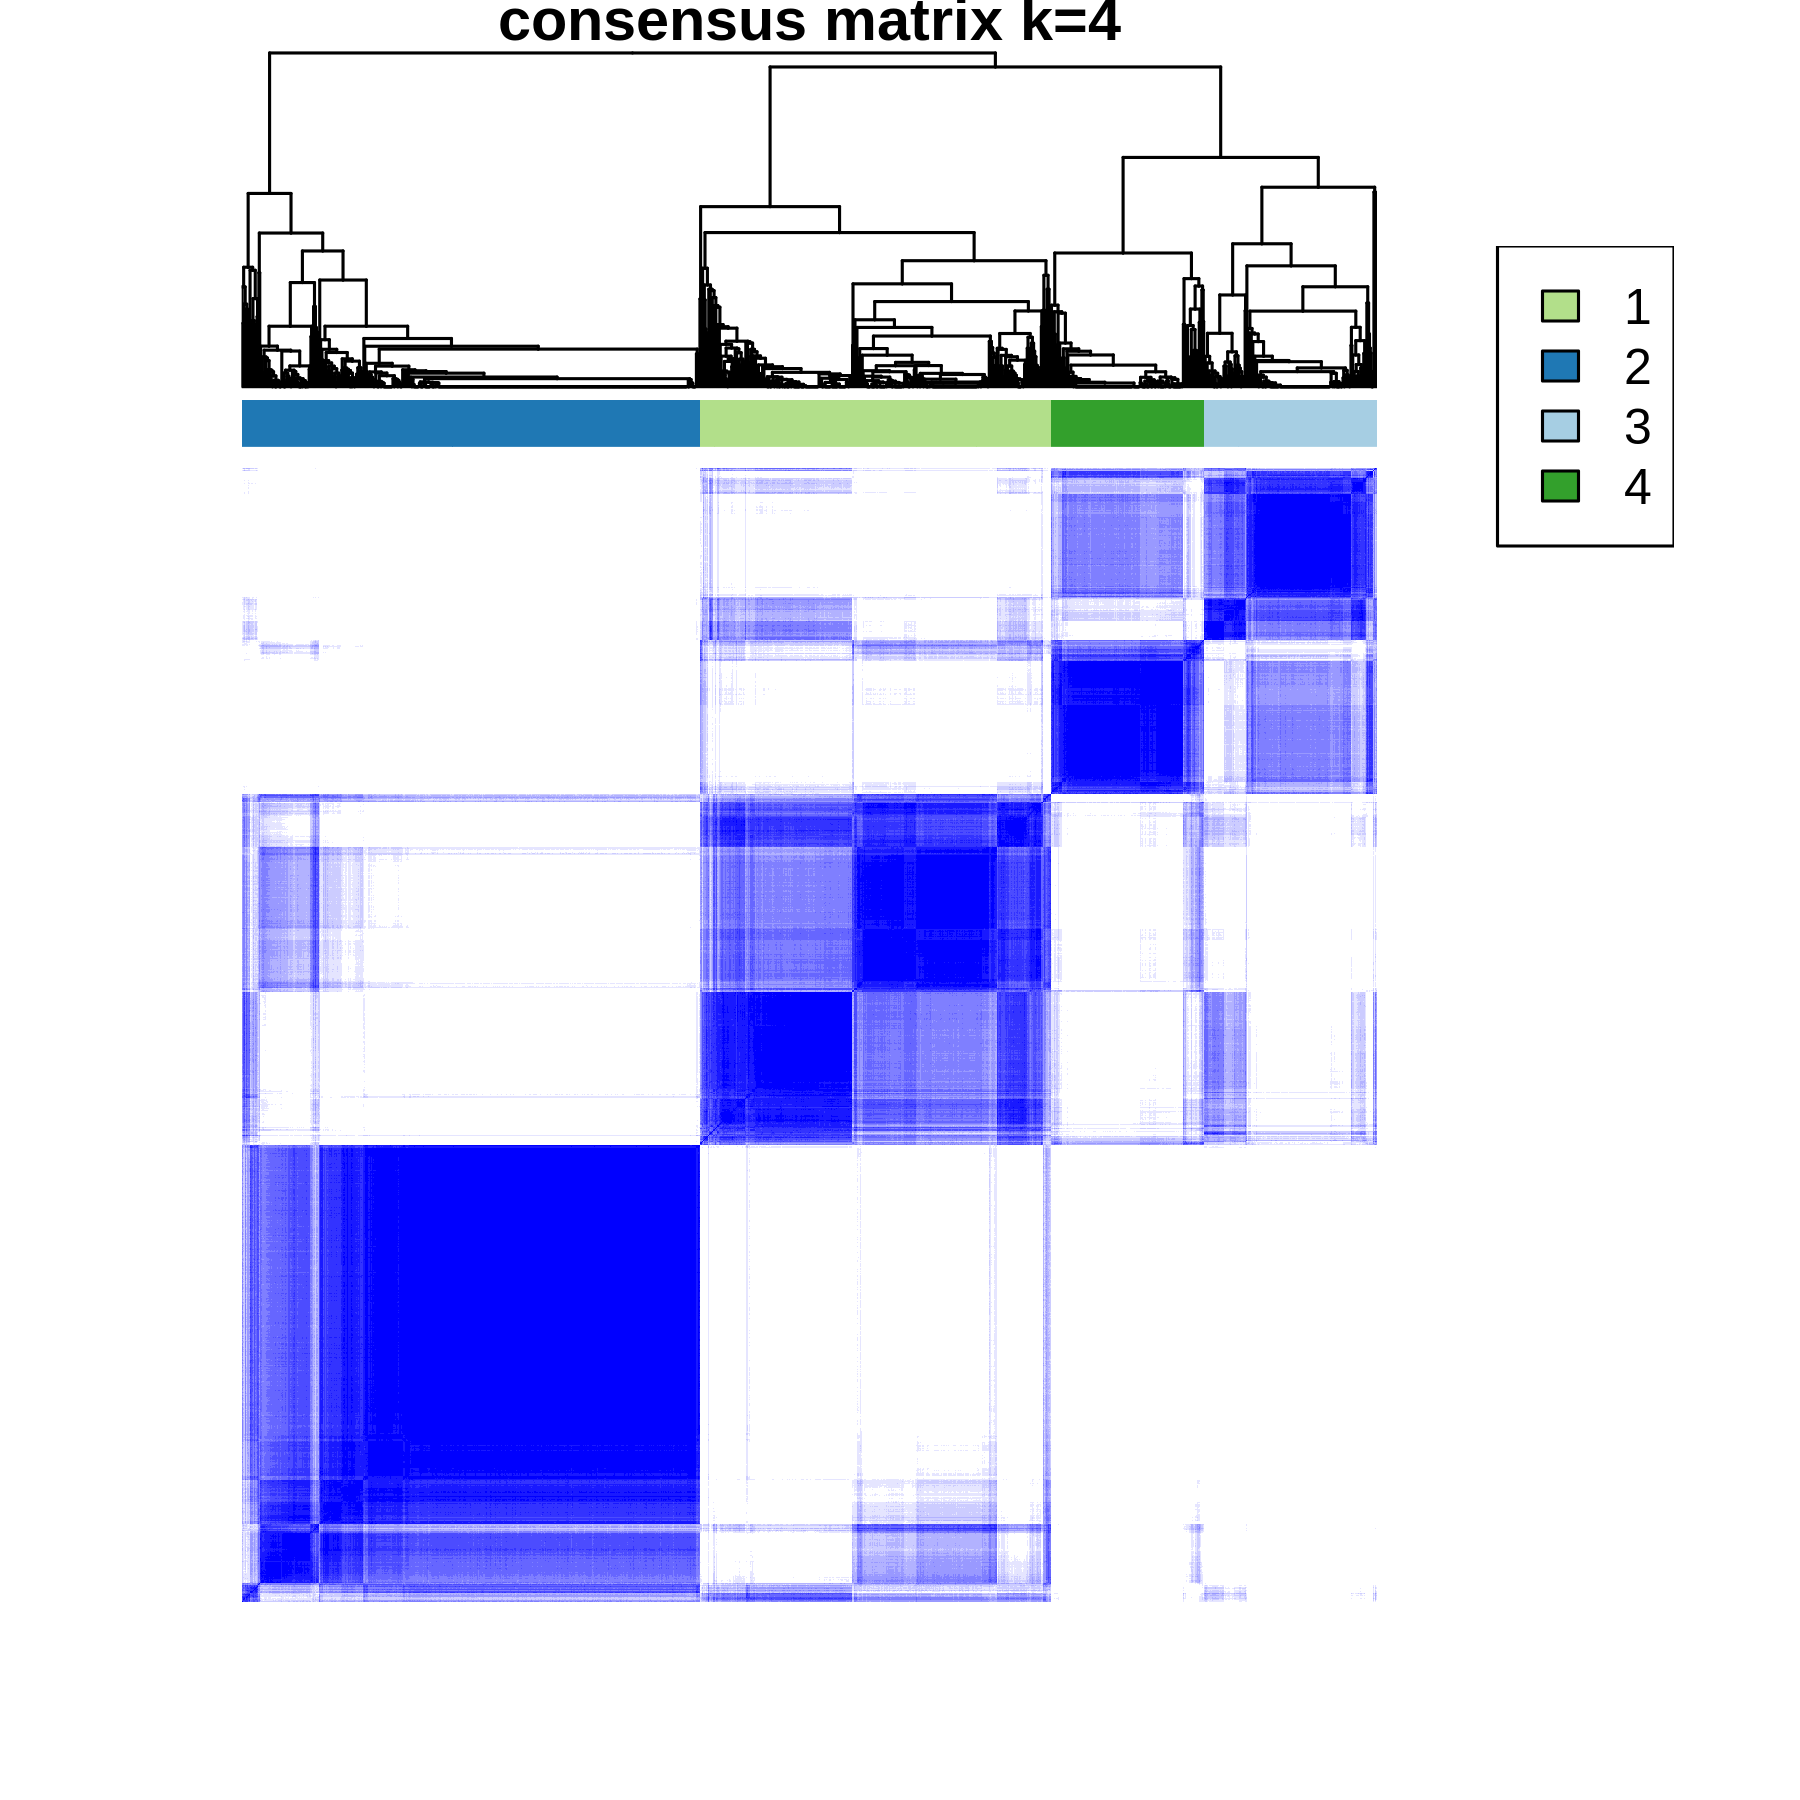

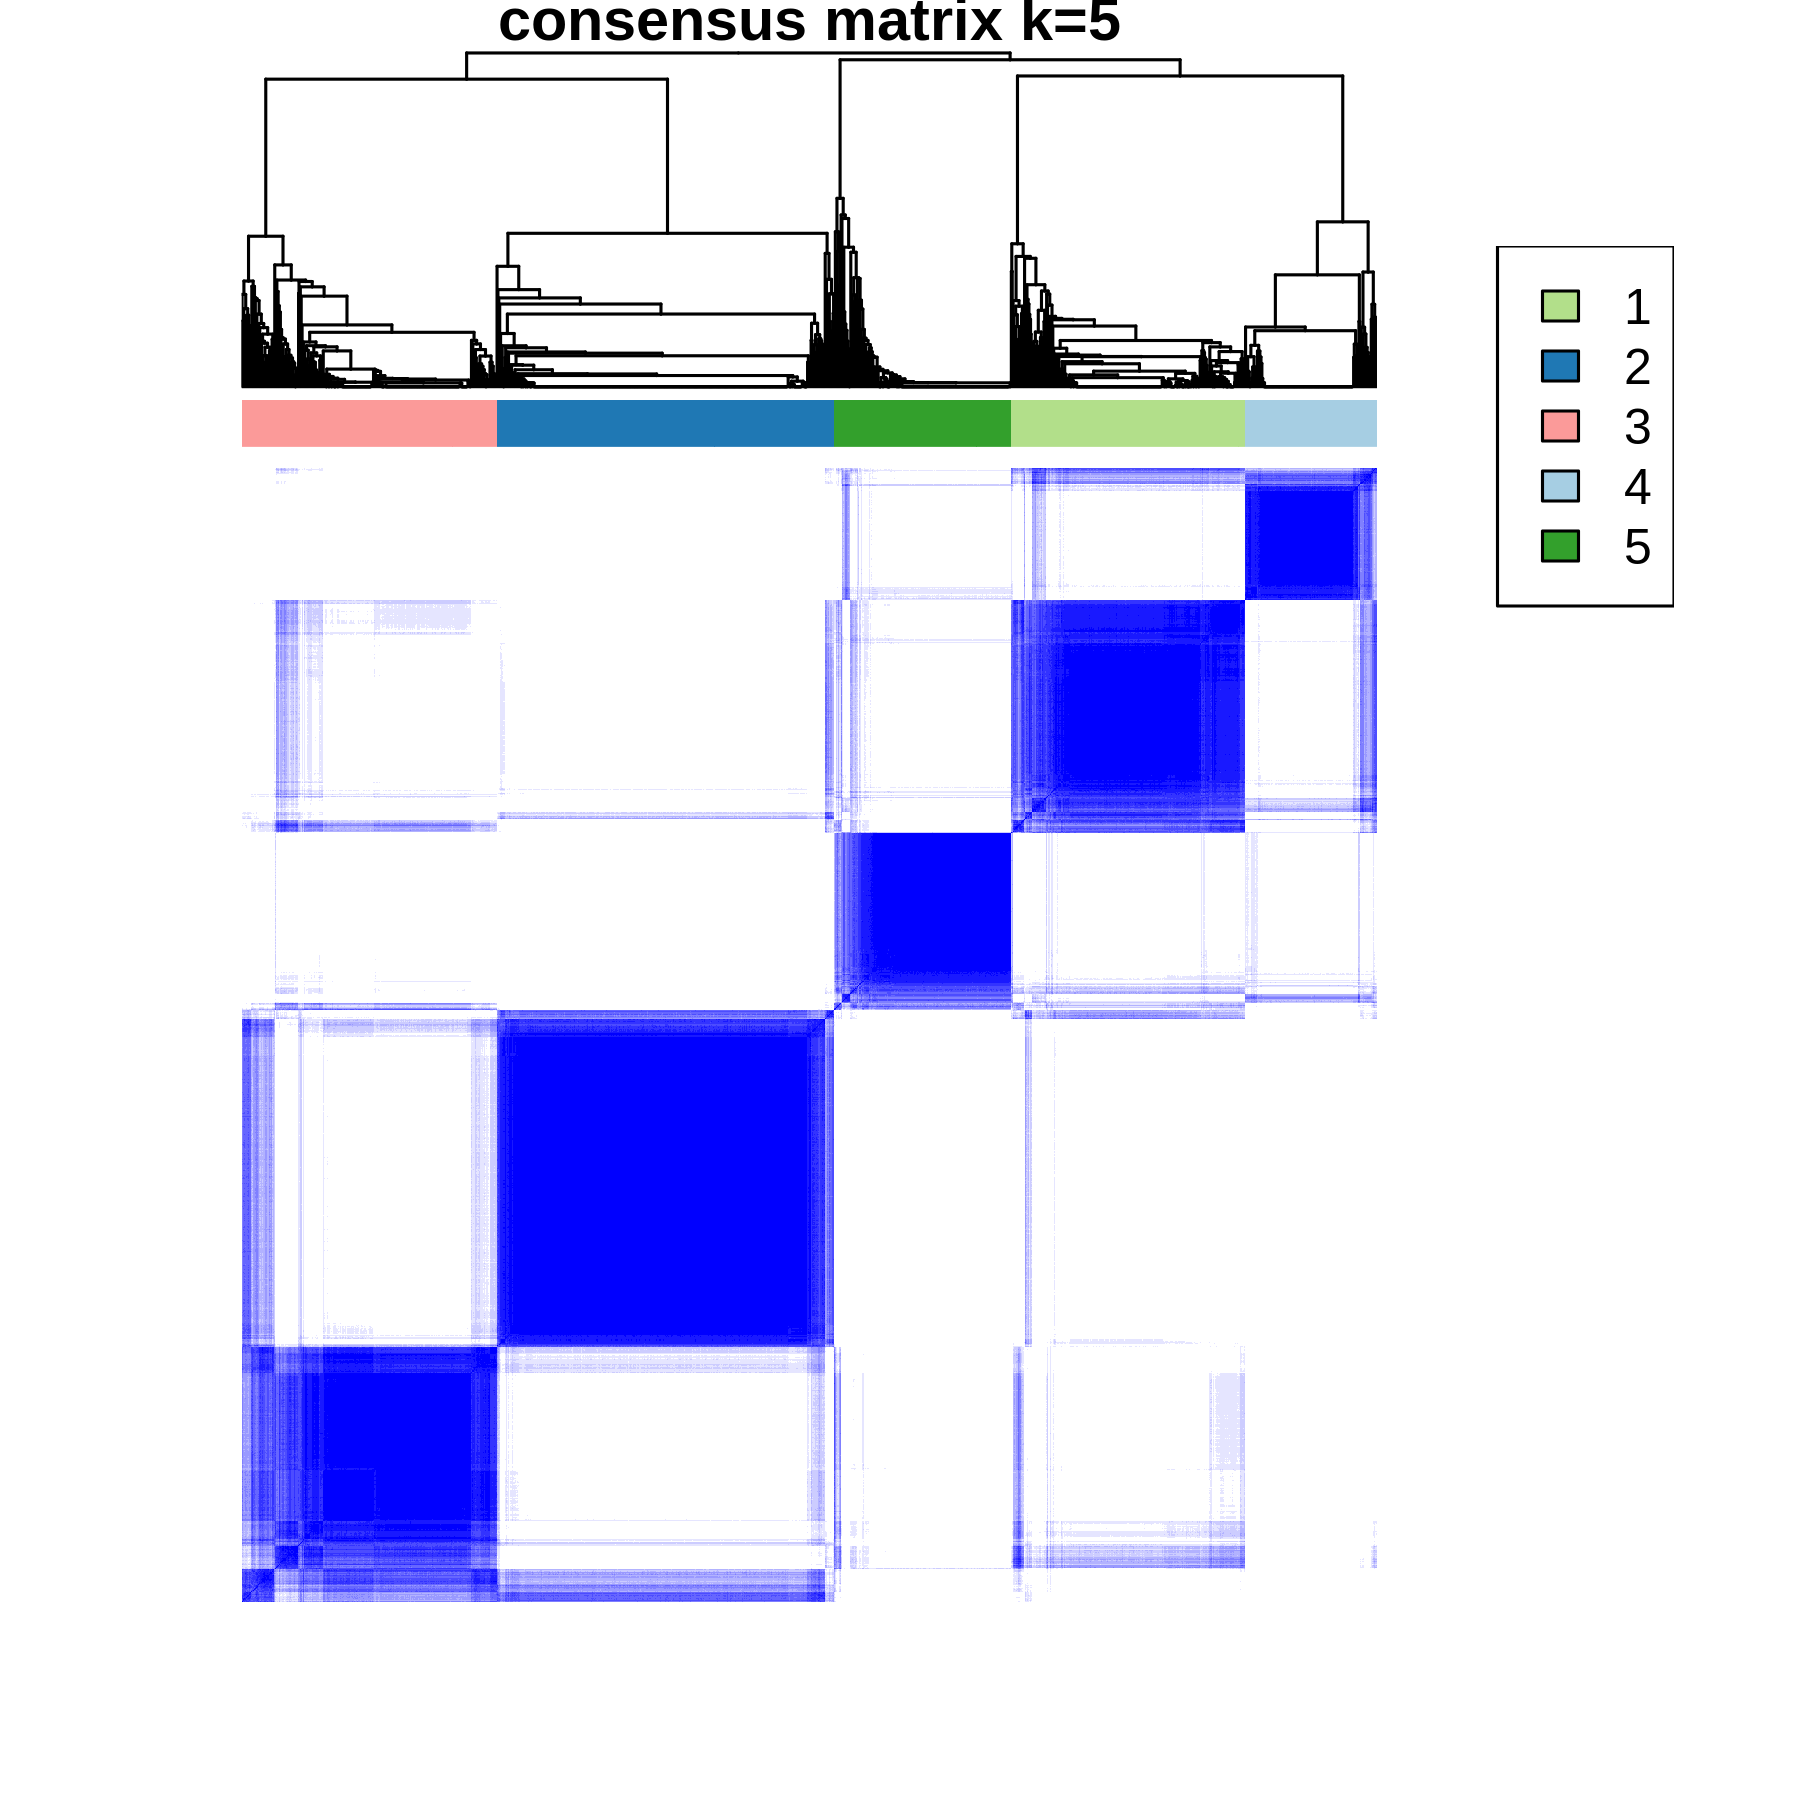

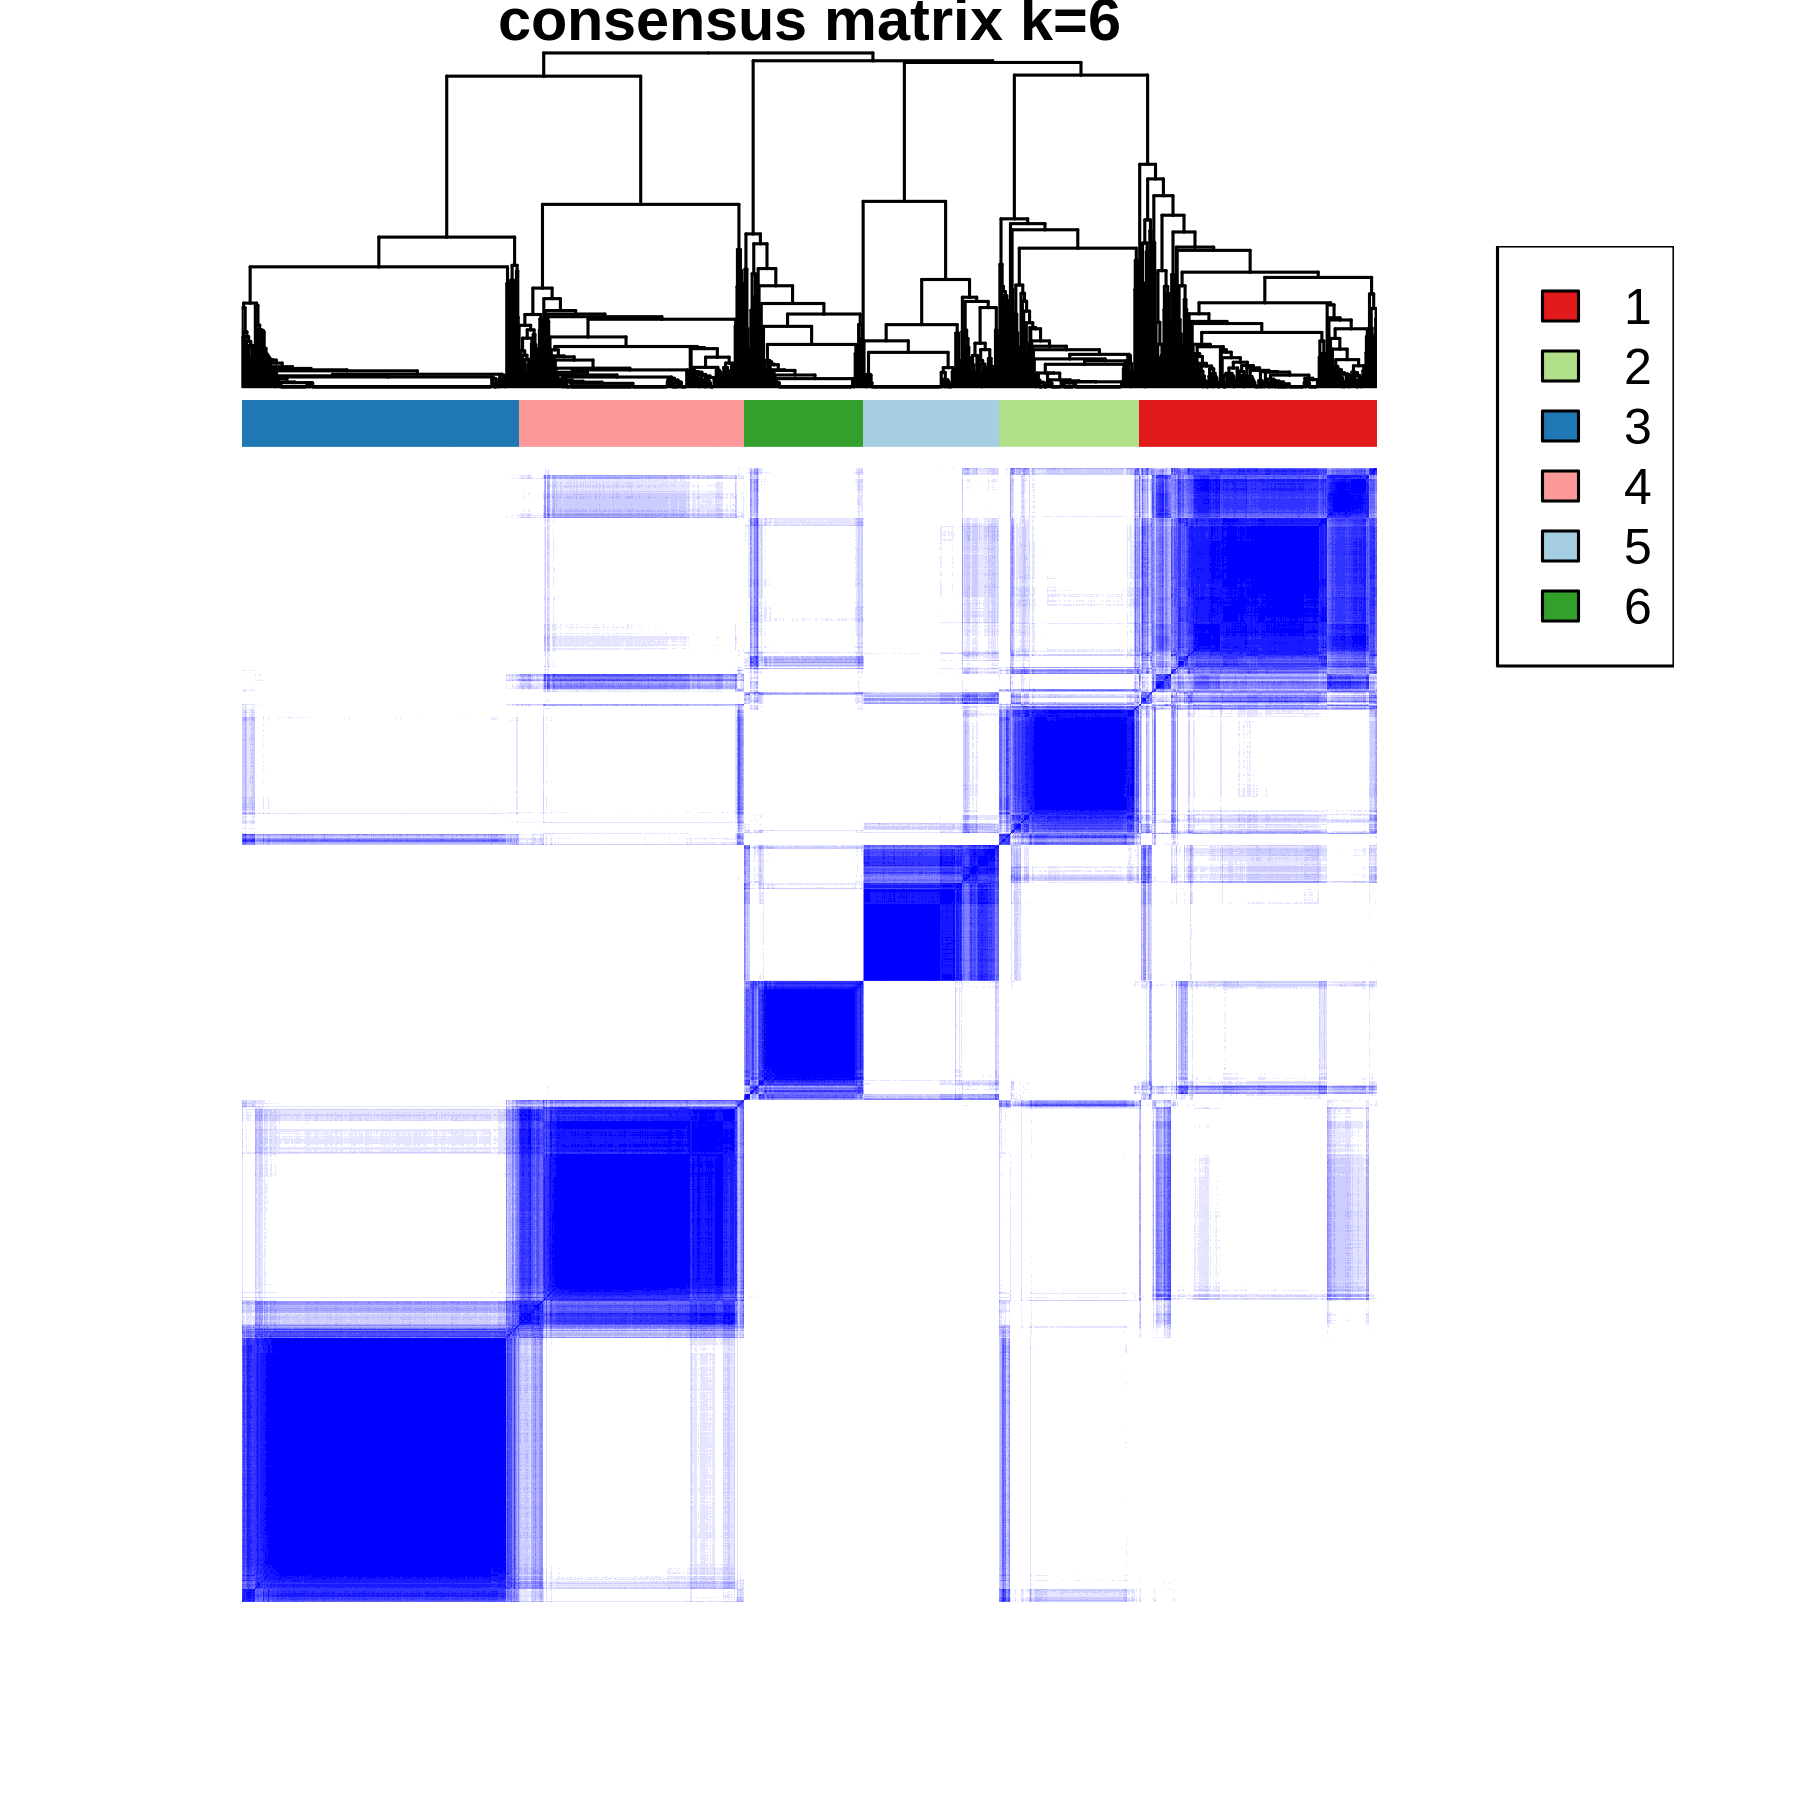

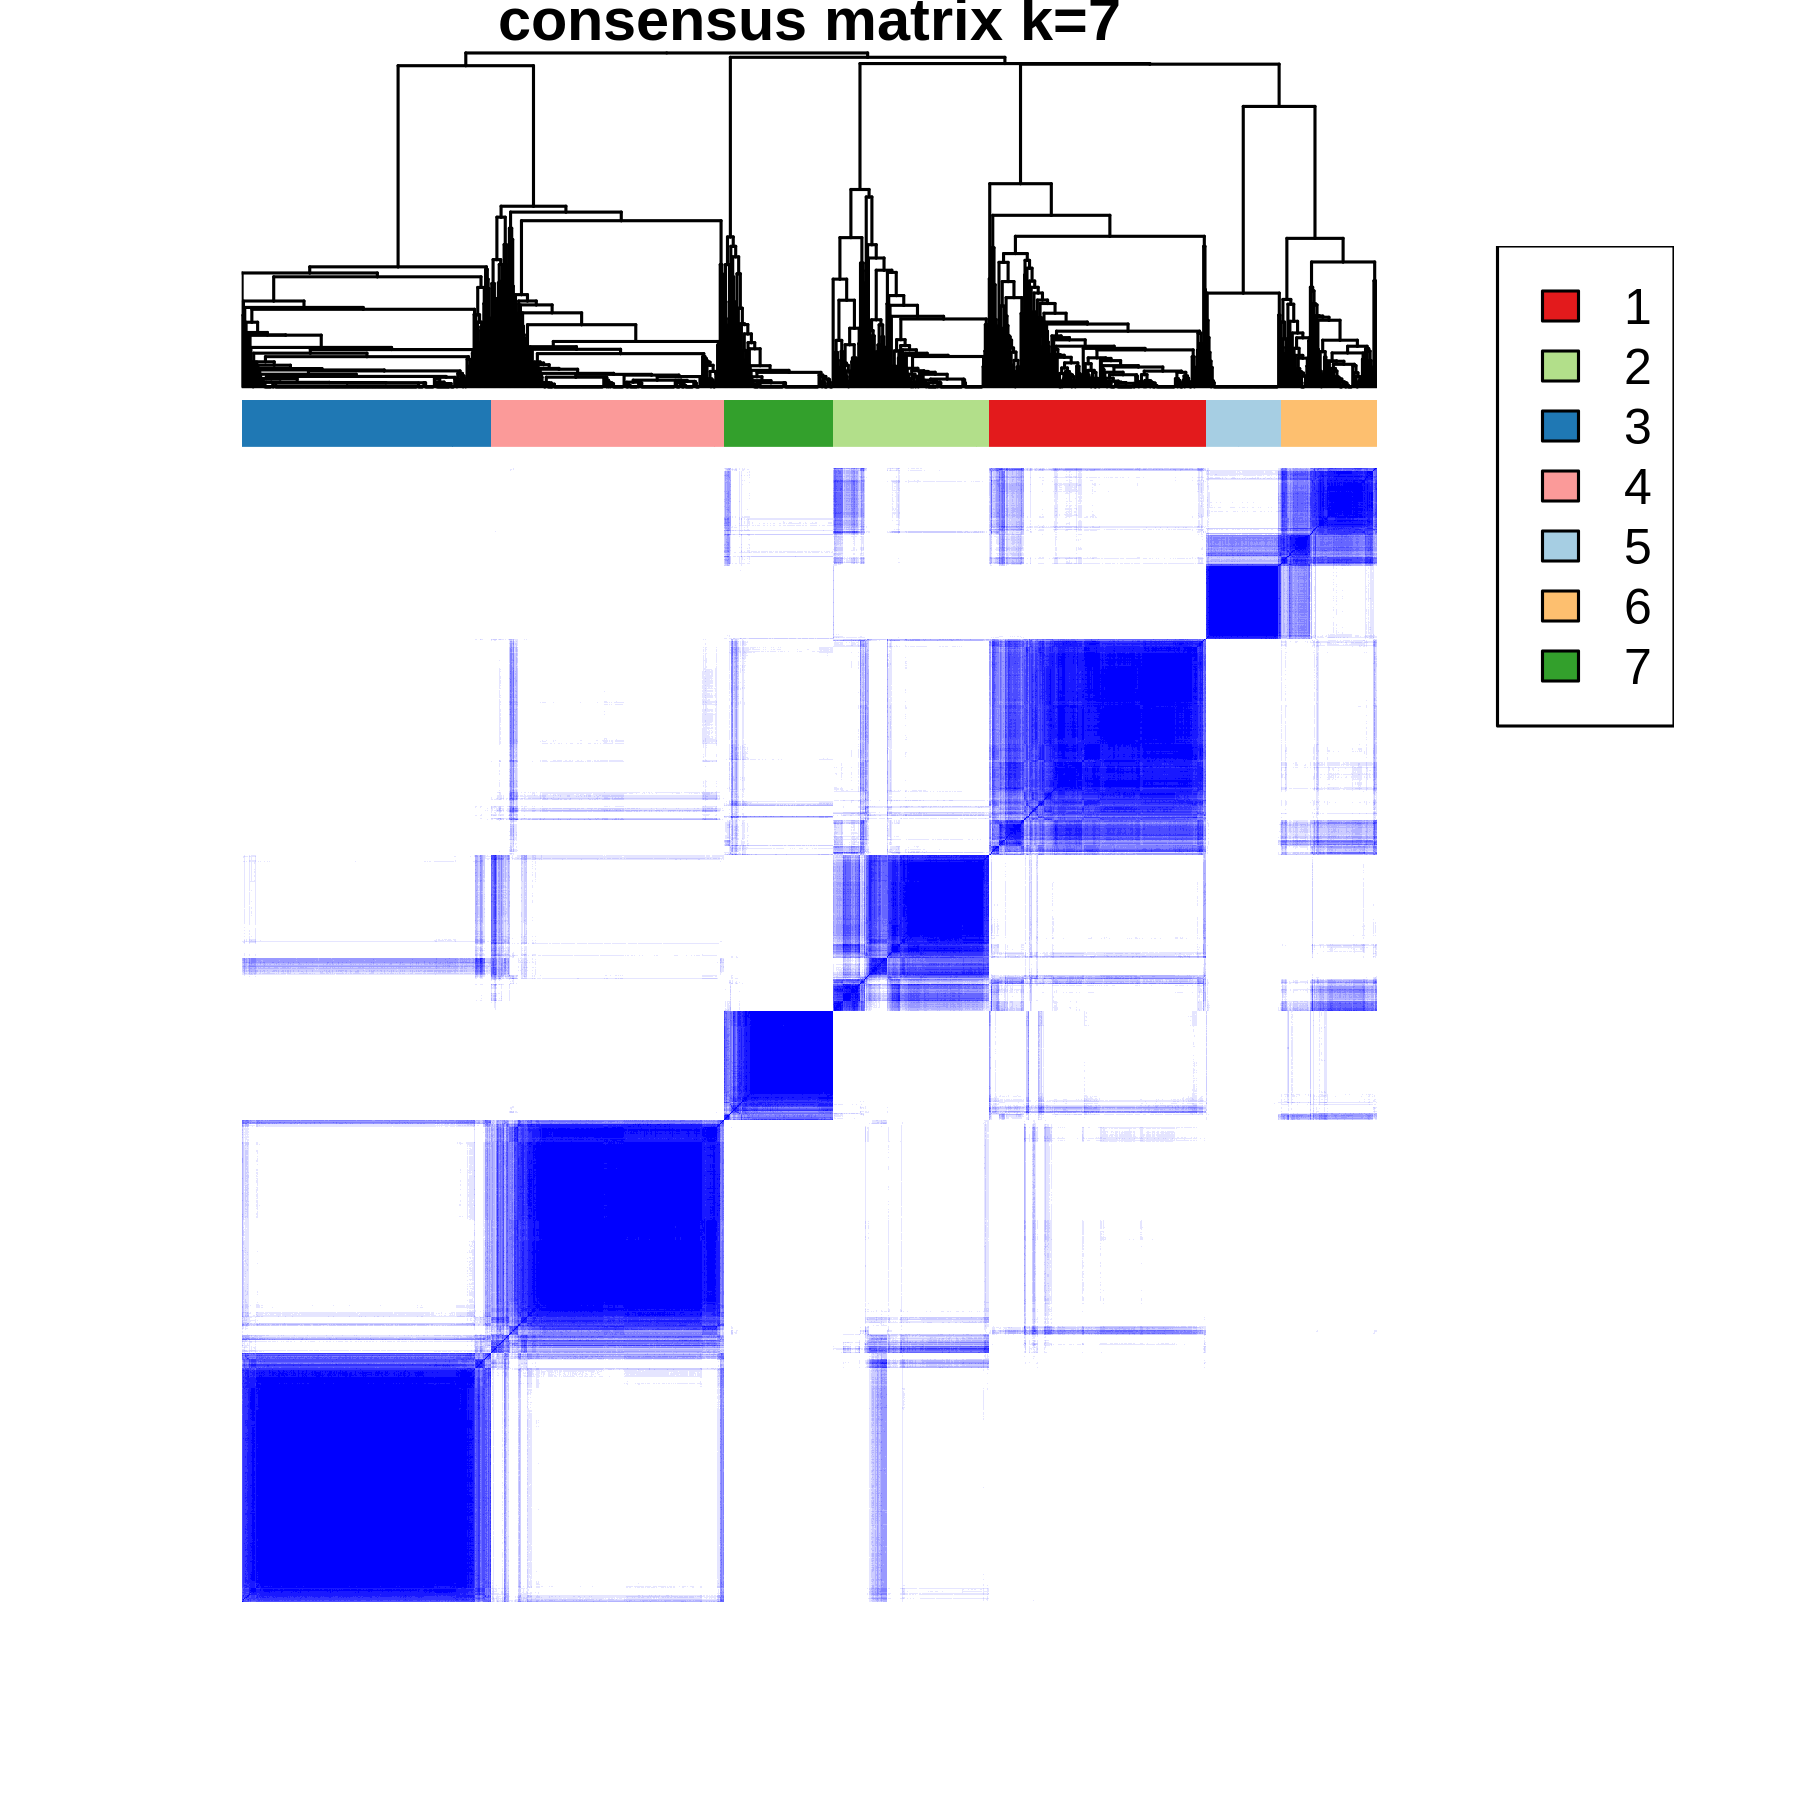

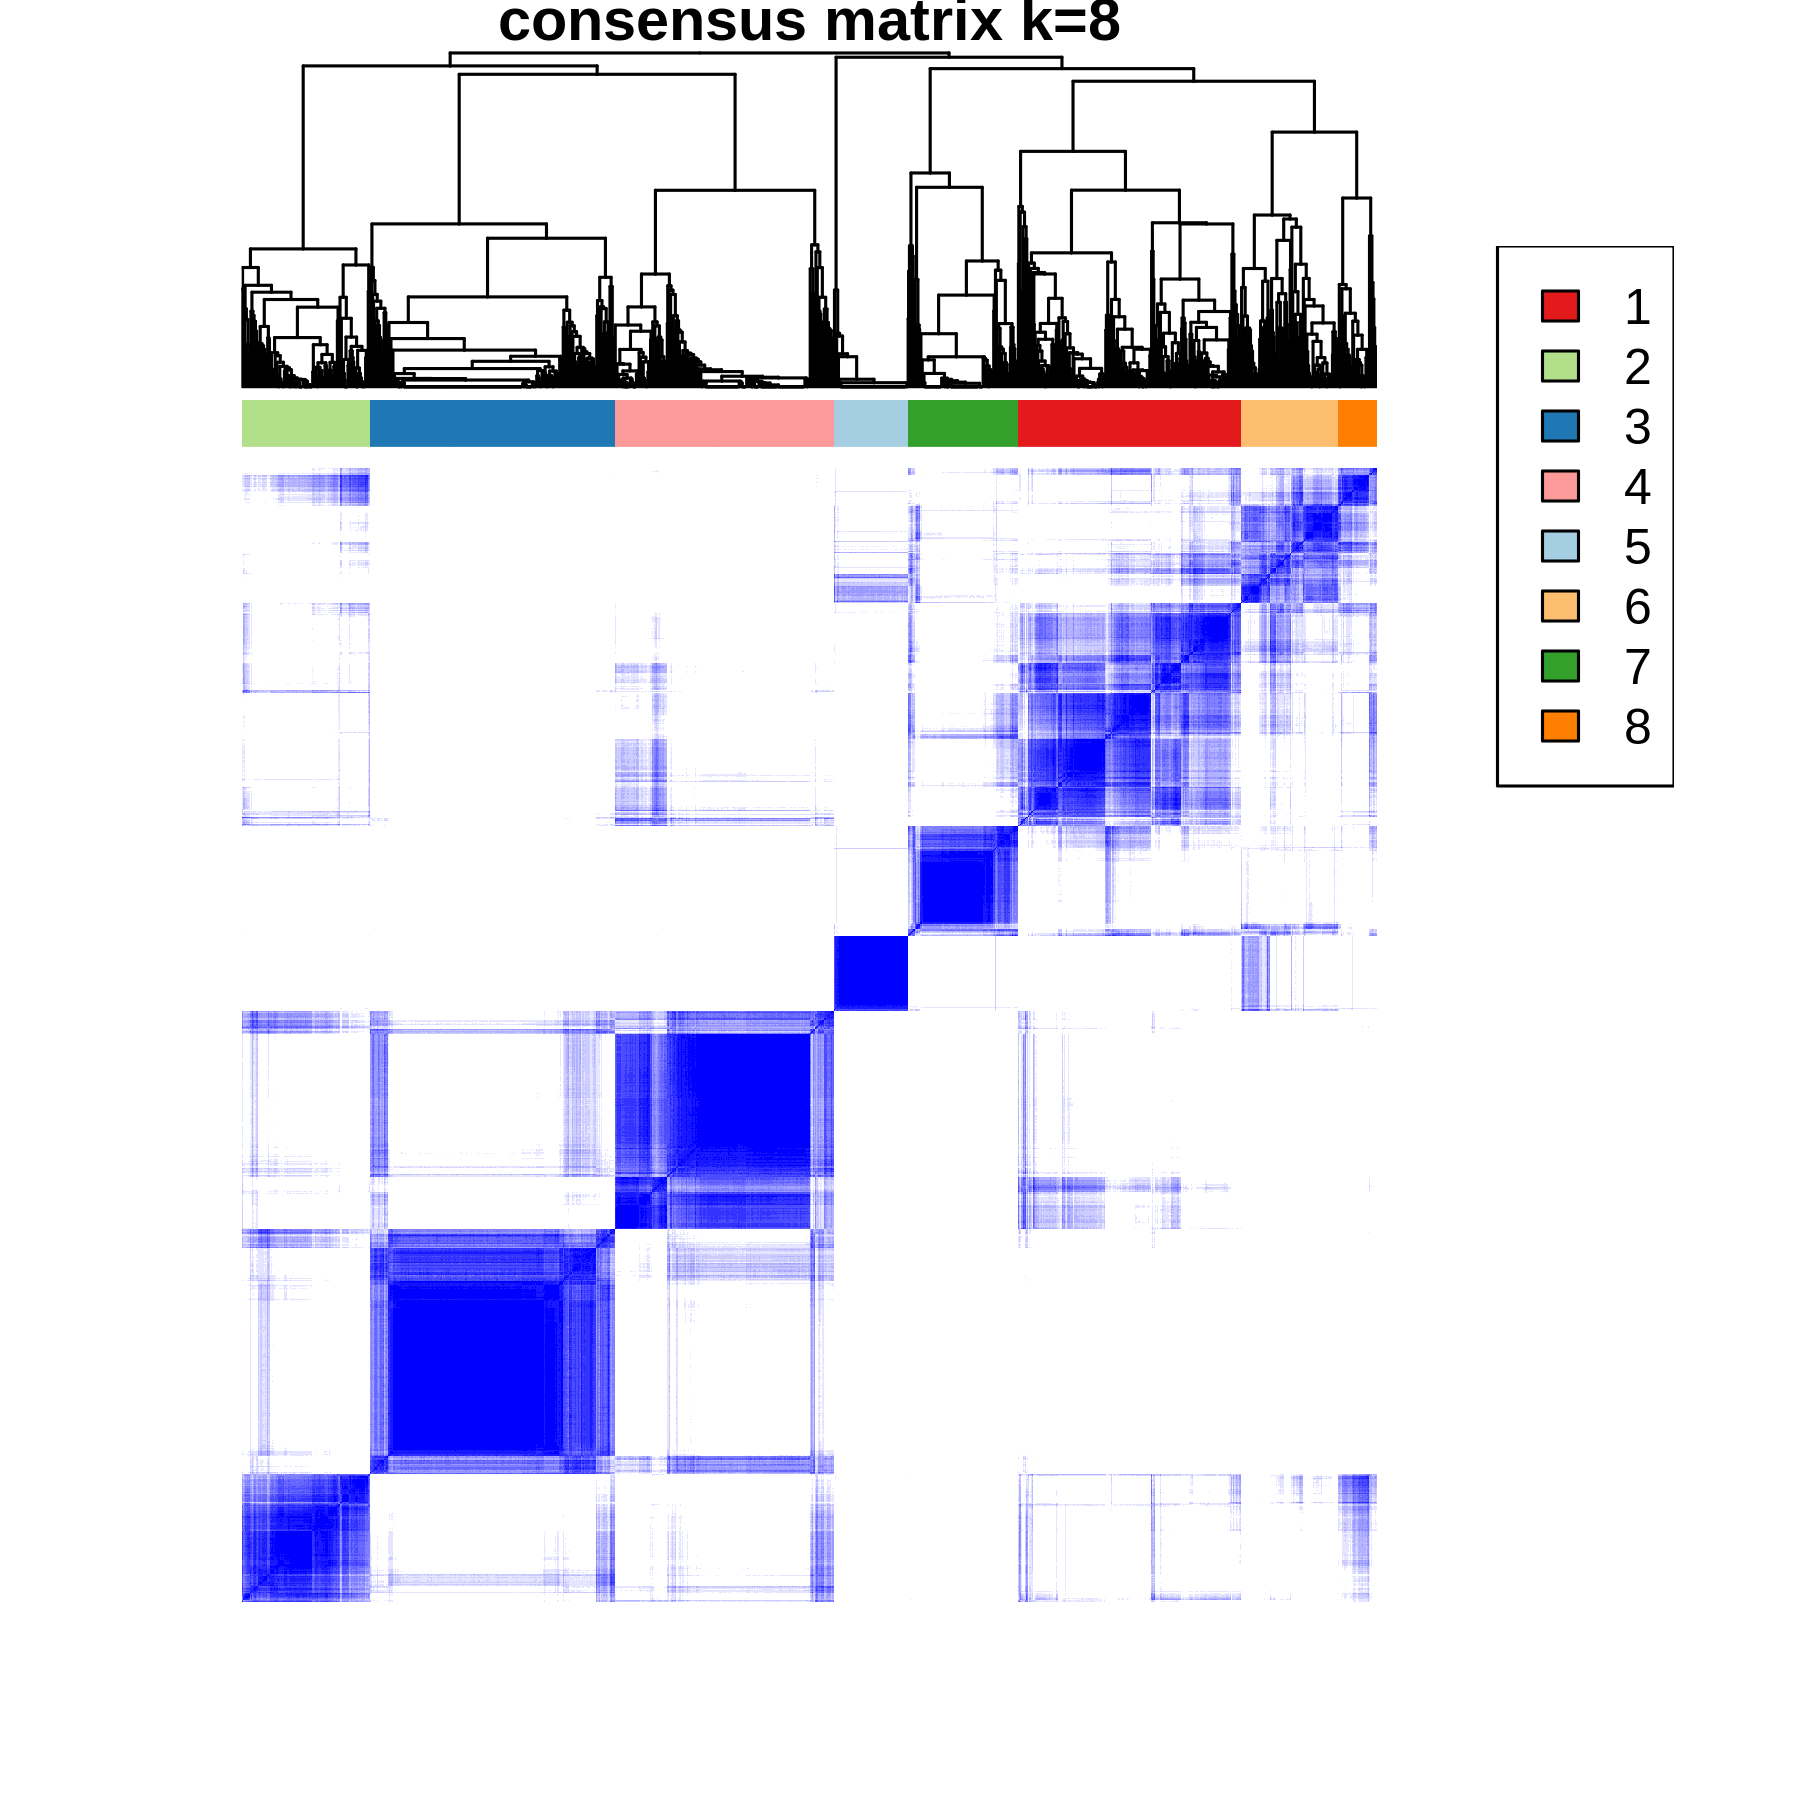

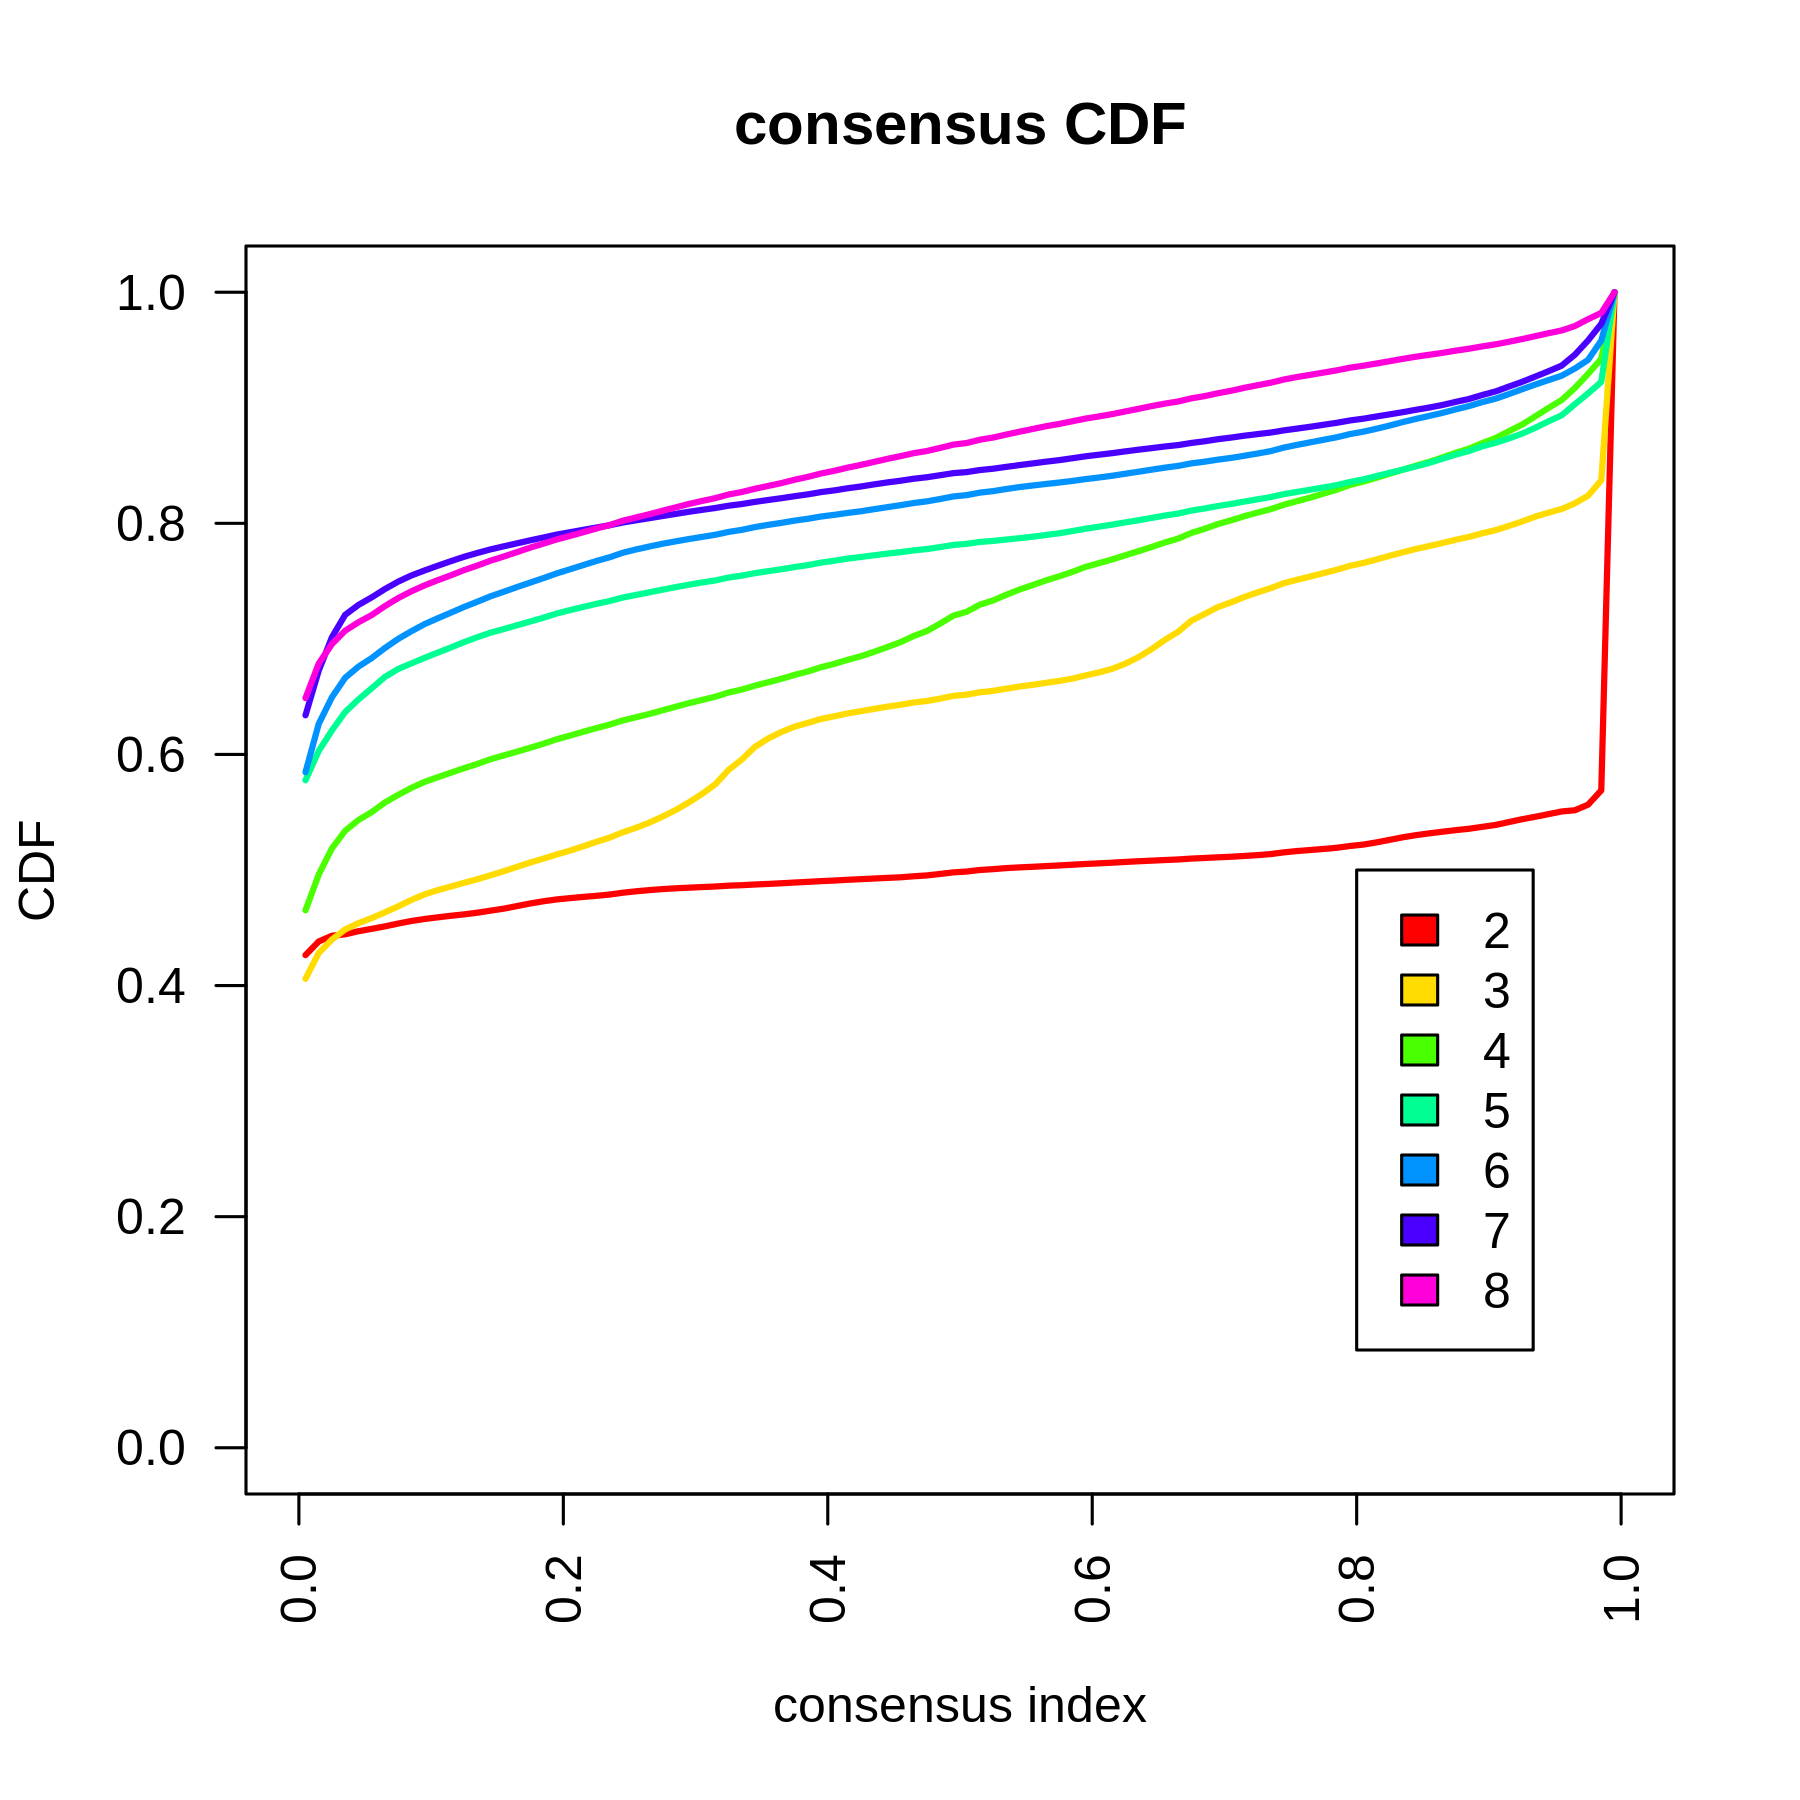

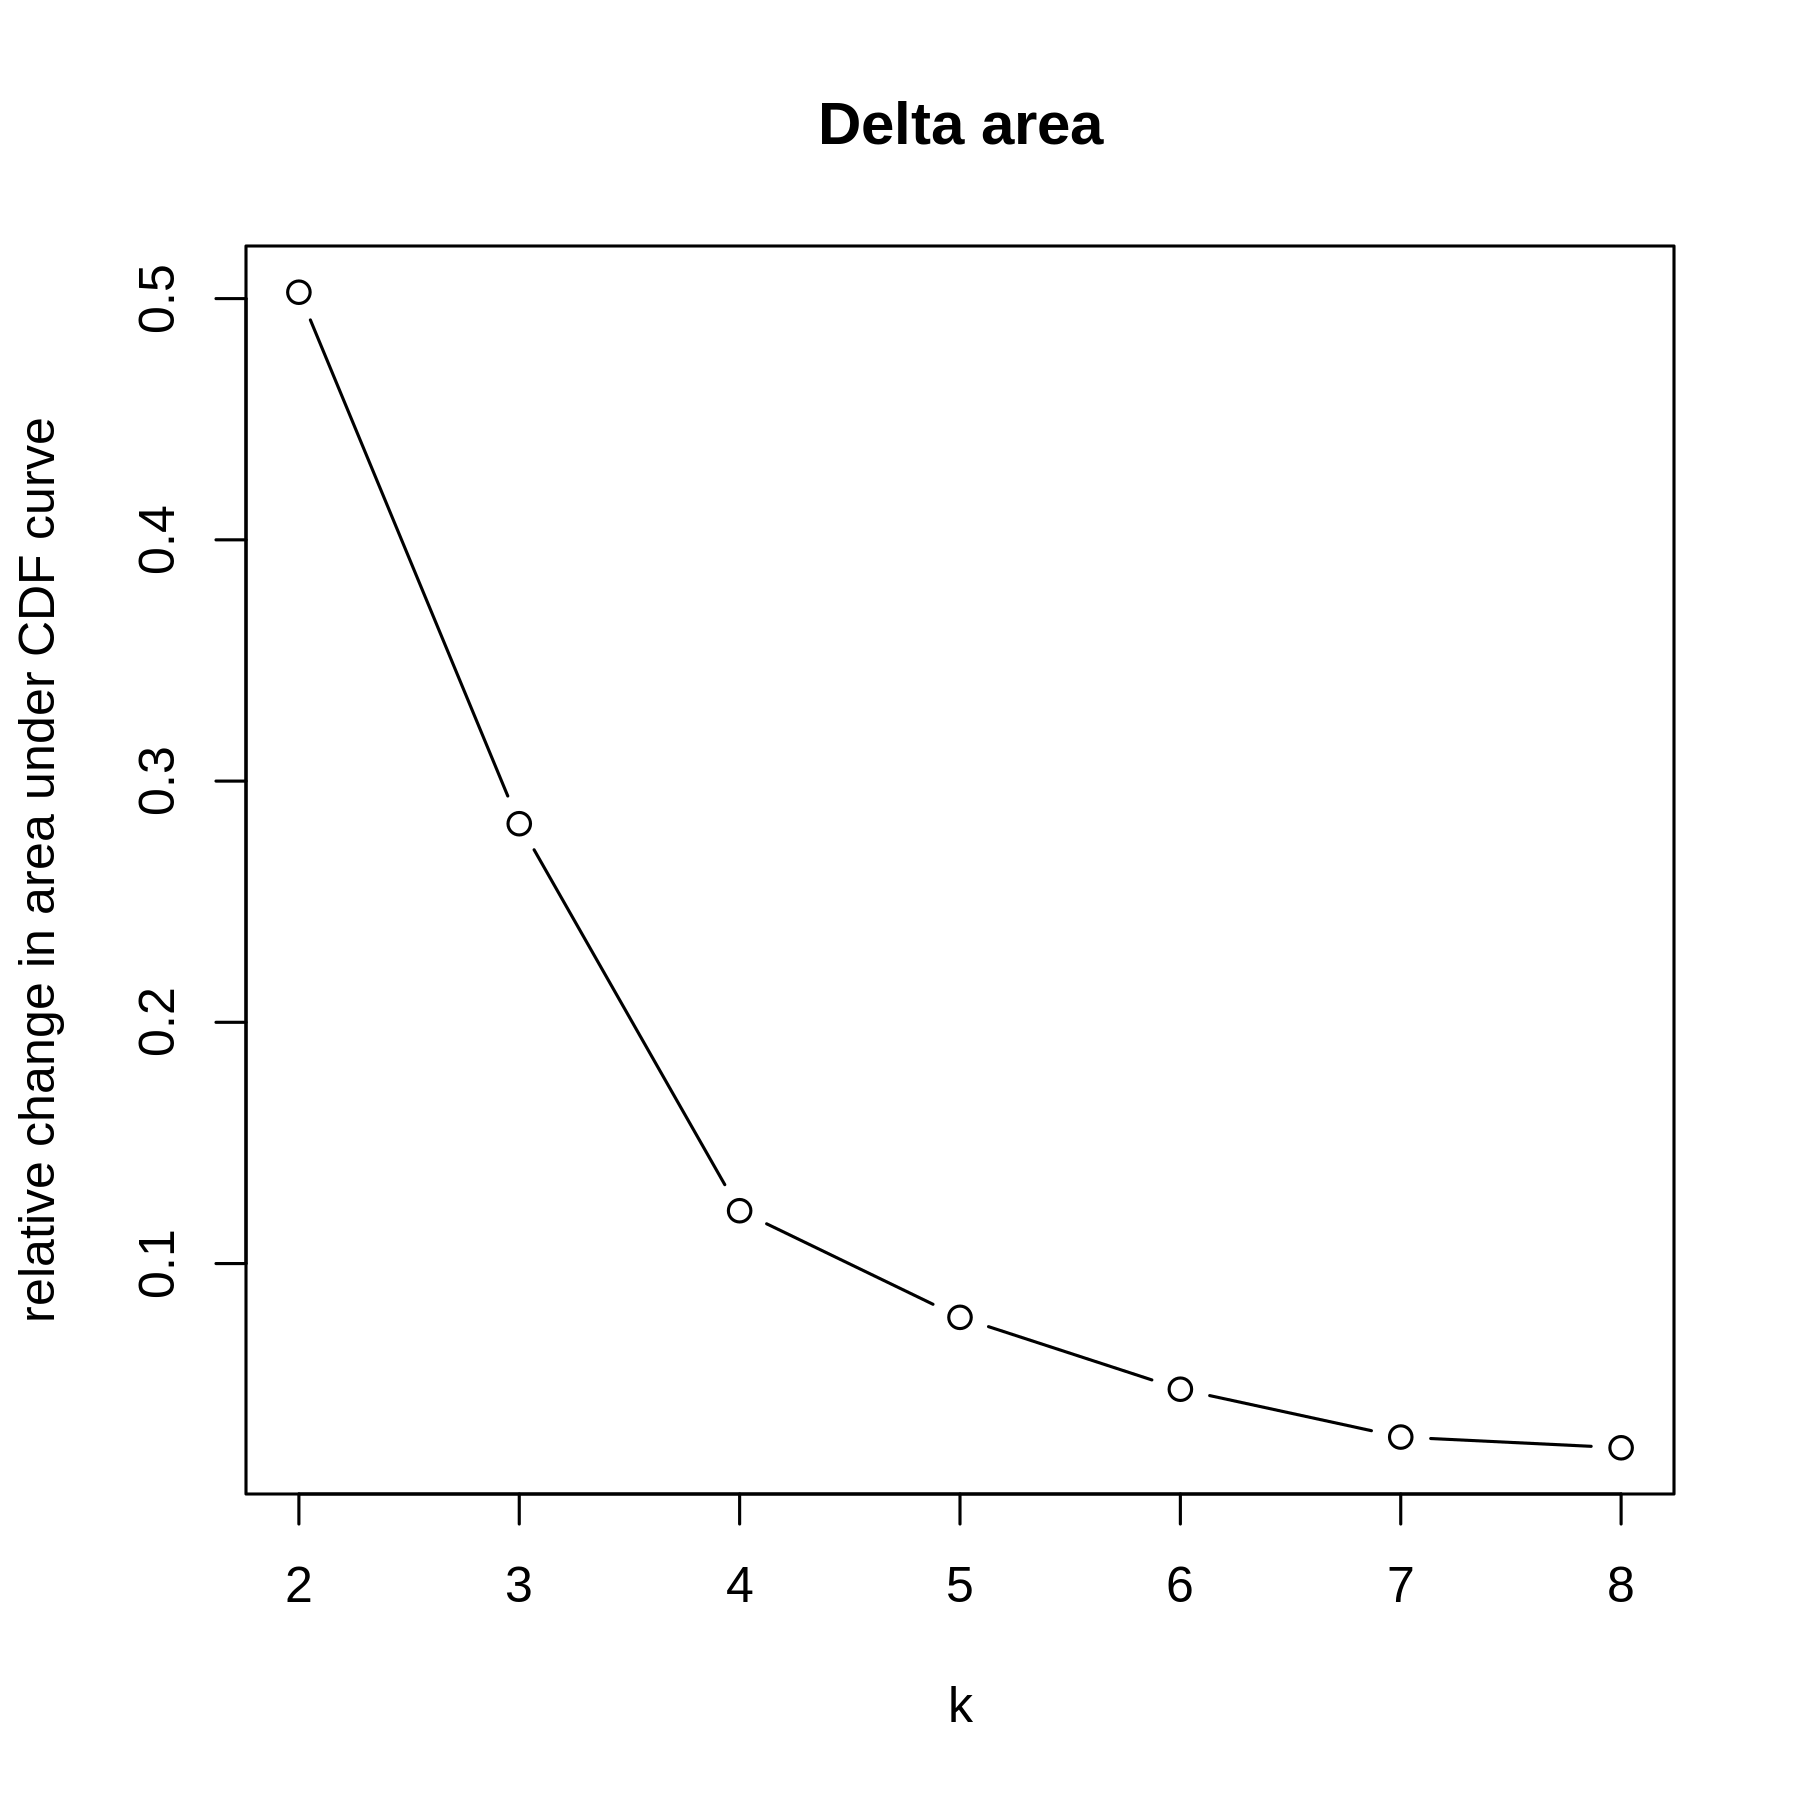

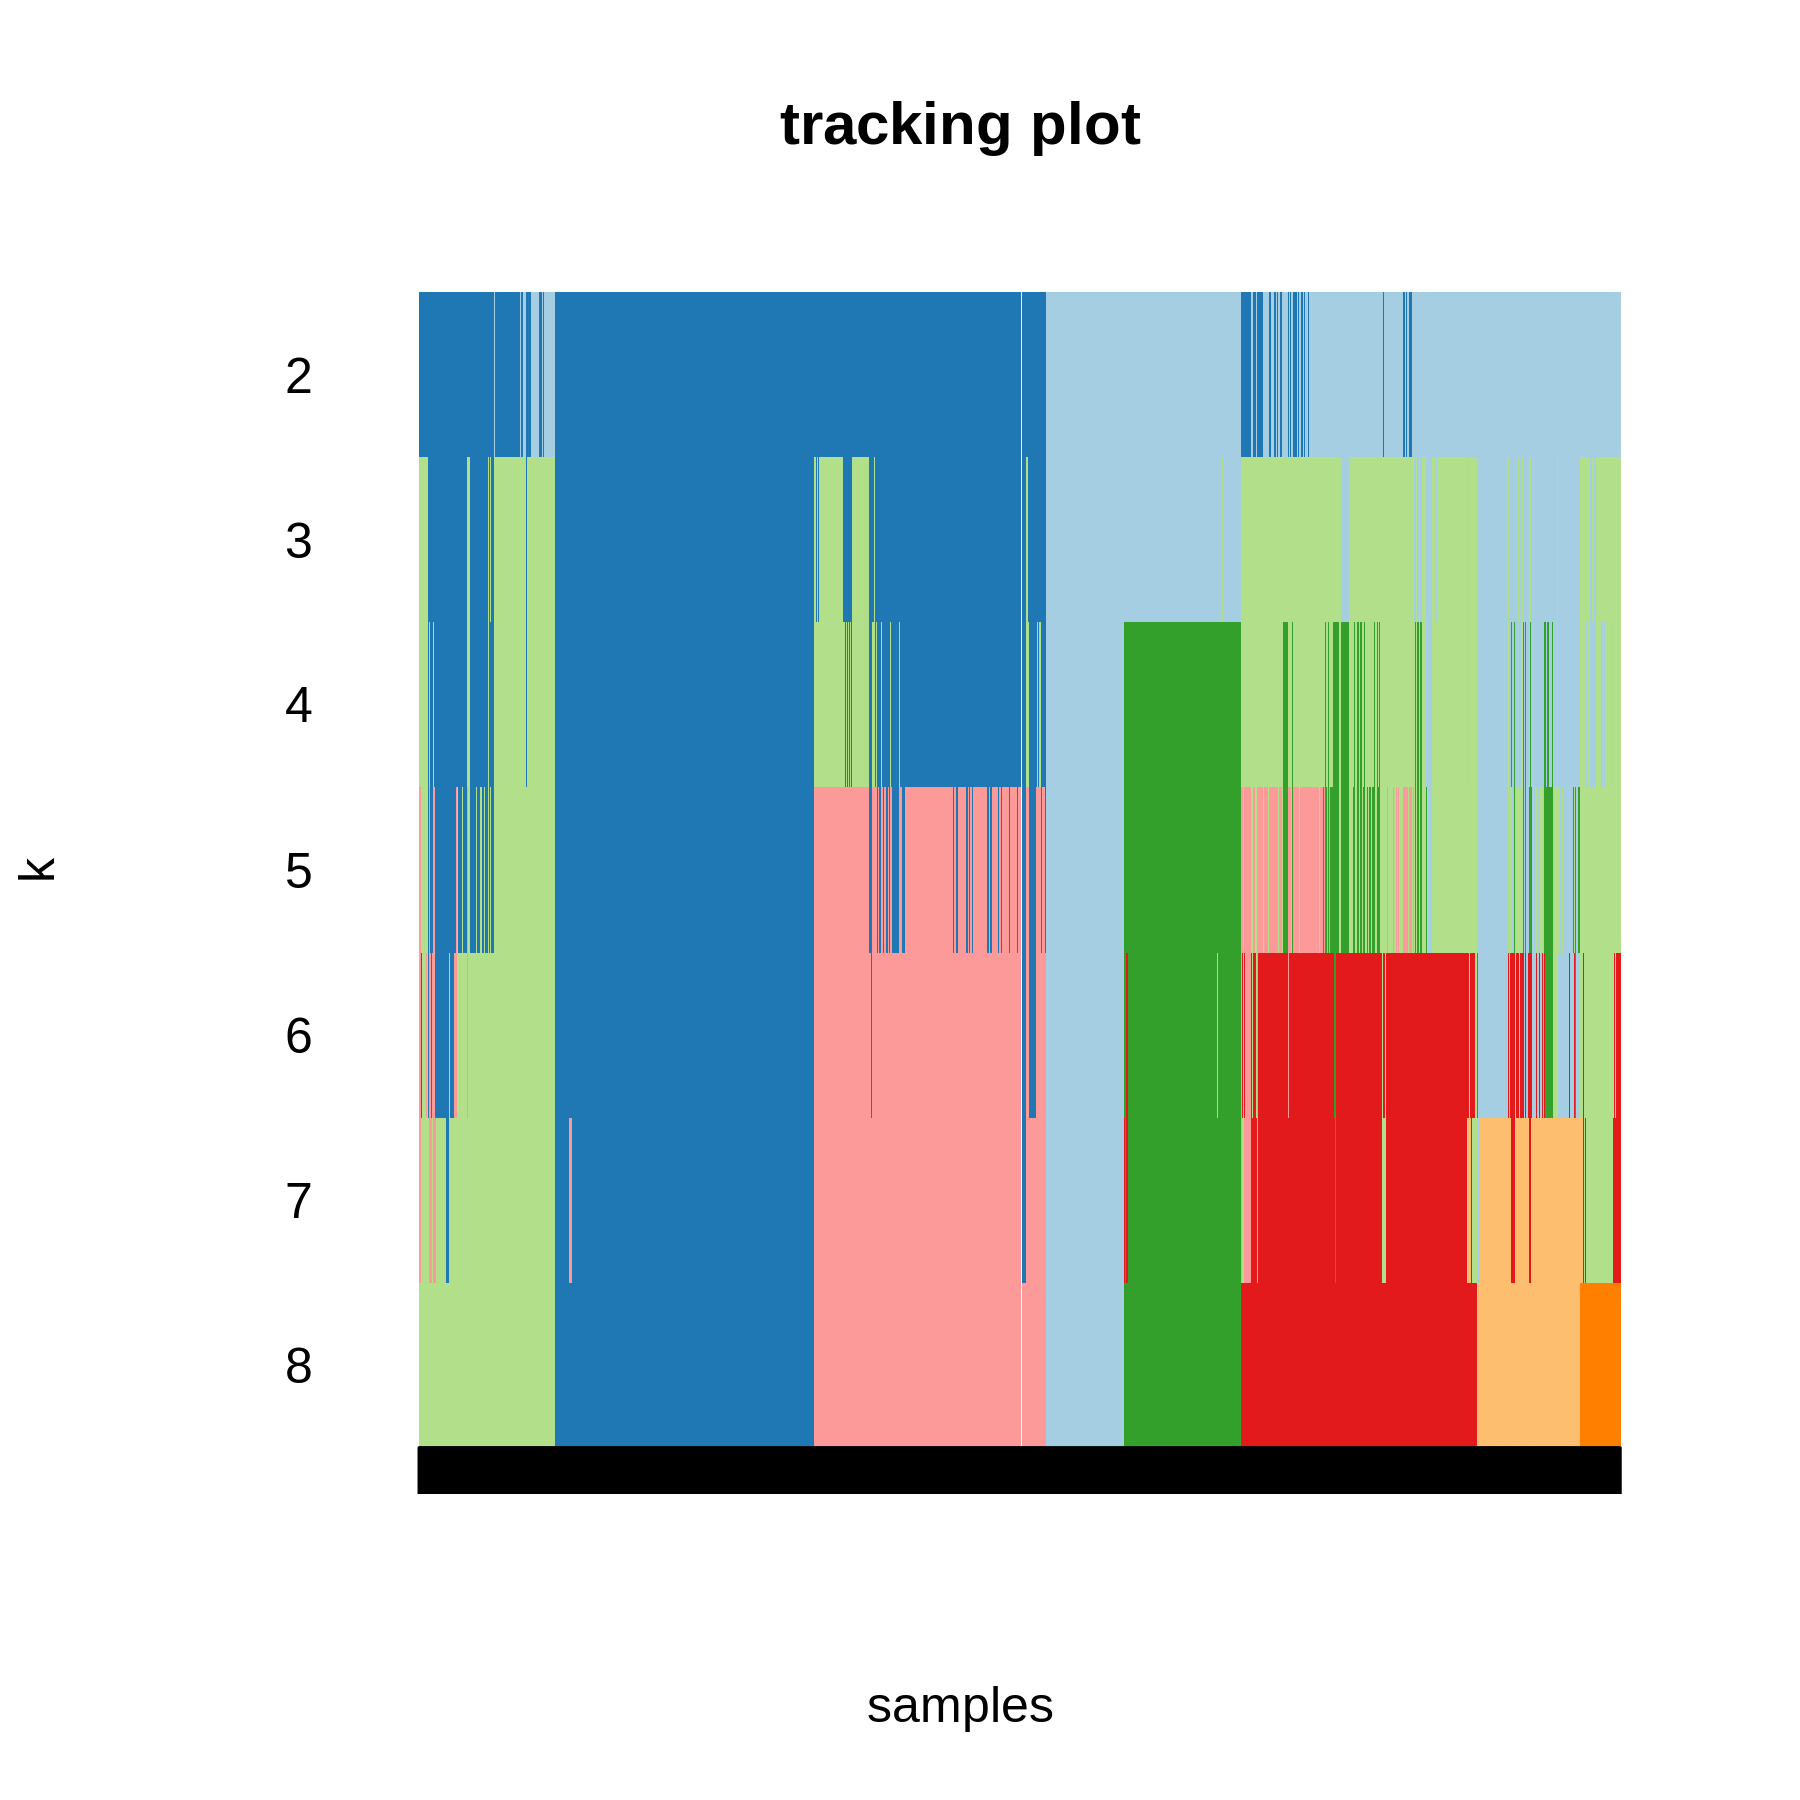

In [17]:
%%R -i Br,samples_name,factor_name  -o Cluster_results -w 6 -h 6 --units in -r 300

rownames(Br) = samples_name
colnames(Br) = factor_name
Cluster_results = ConsensusClusterPlus(t(apply(Br, 2, scale)), maxK = 8, rep = 100, pItem = 0.9, 
                             pFeature = 0.9, clusterAlg = "km", distance = "euclidean",seed = 2314)



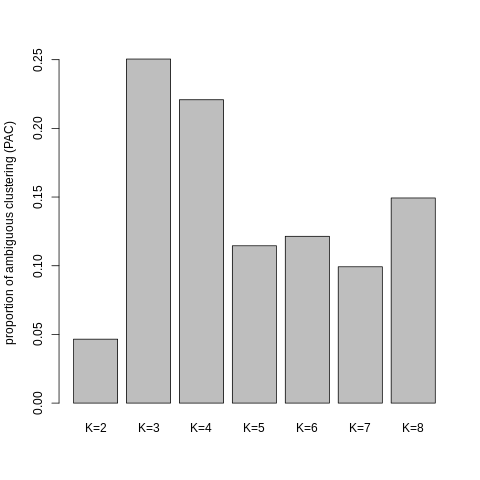

In [45]:
%%R -i Cluster_results

threshold = 0.8
cc_score = c()

for (i in seq(2,8)){
    x = (Cluster_results[i][[1]]$consensusMatrix)
    #print(x)
    cc_score = c(cc_score, 1 - (length(x[x > threshold]) + length(x[x < (1- threshold)]))/length(x))
}

barplot(cc_score, ylab = 'proportion of ambiguous clustering (PAC)', names.arg=c("K=2","K=3","K=4","K=5","K=6","K=7","K=8"))


In [20]:
cluster_sele = 5  #selection of clusters

list_labe = ["S2","S3","S1","S4","S5"] #Reorder the clusters

colors = ['#ff8080','pink','#fdd5ac','#8895df', 'cyan'] #Define the colors for cluster annotation


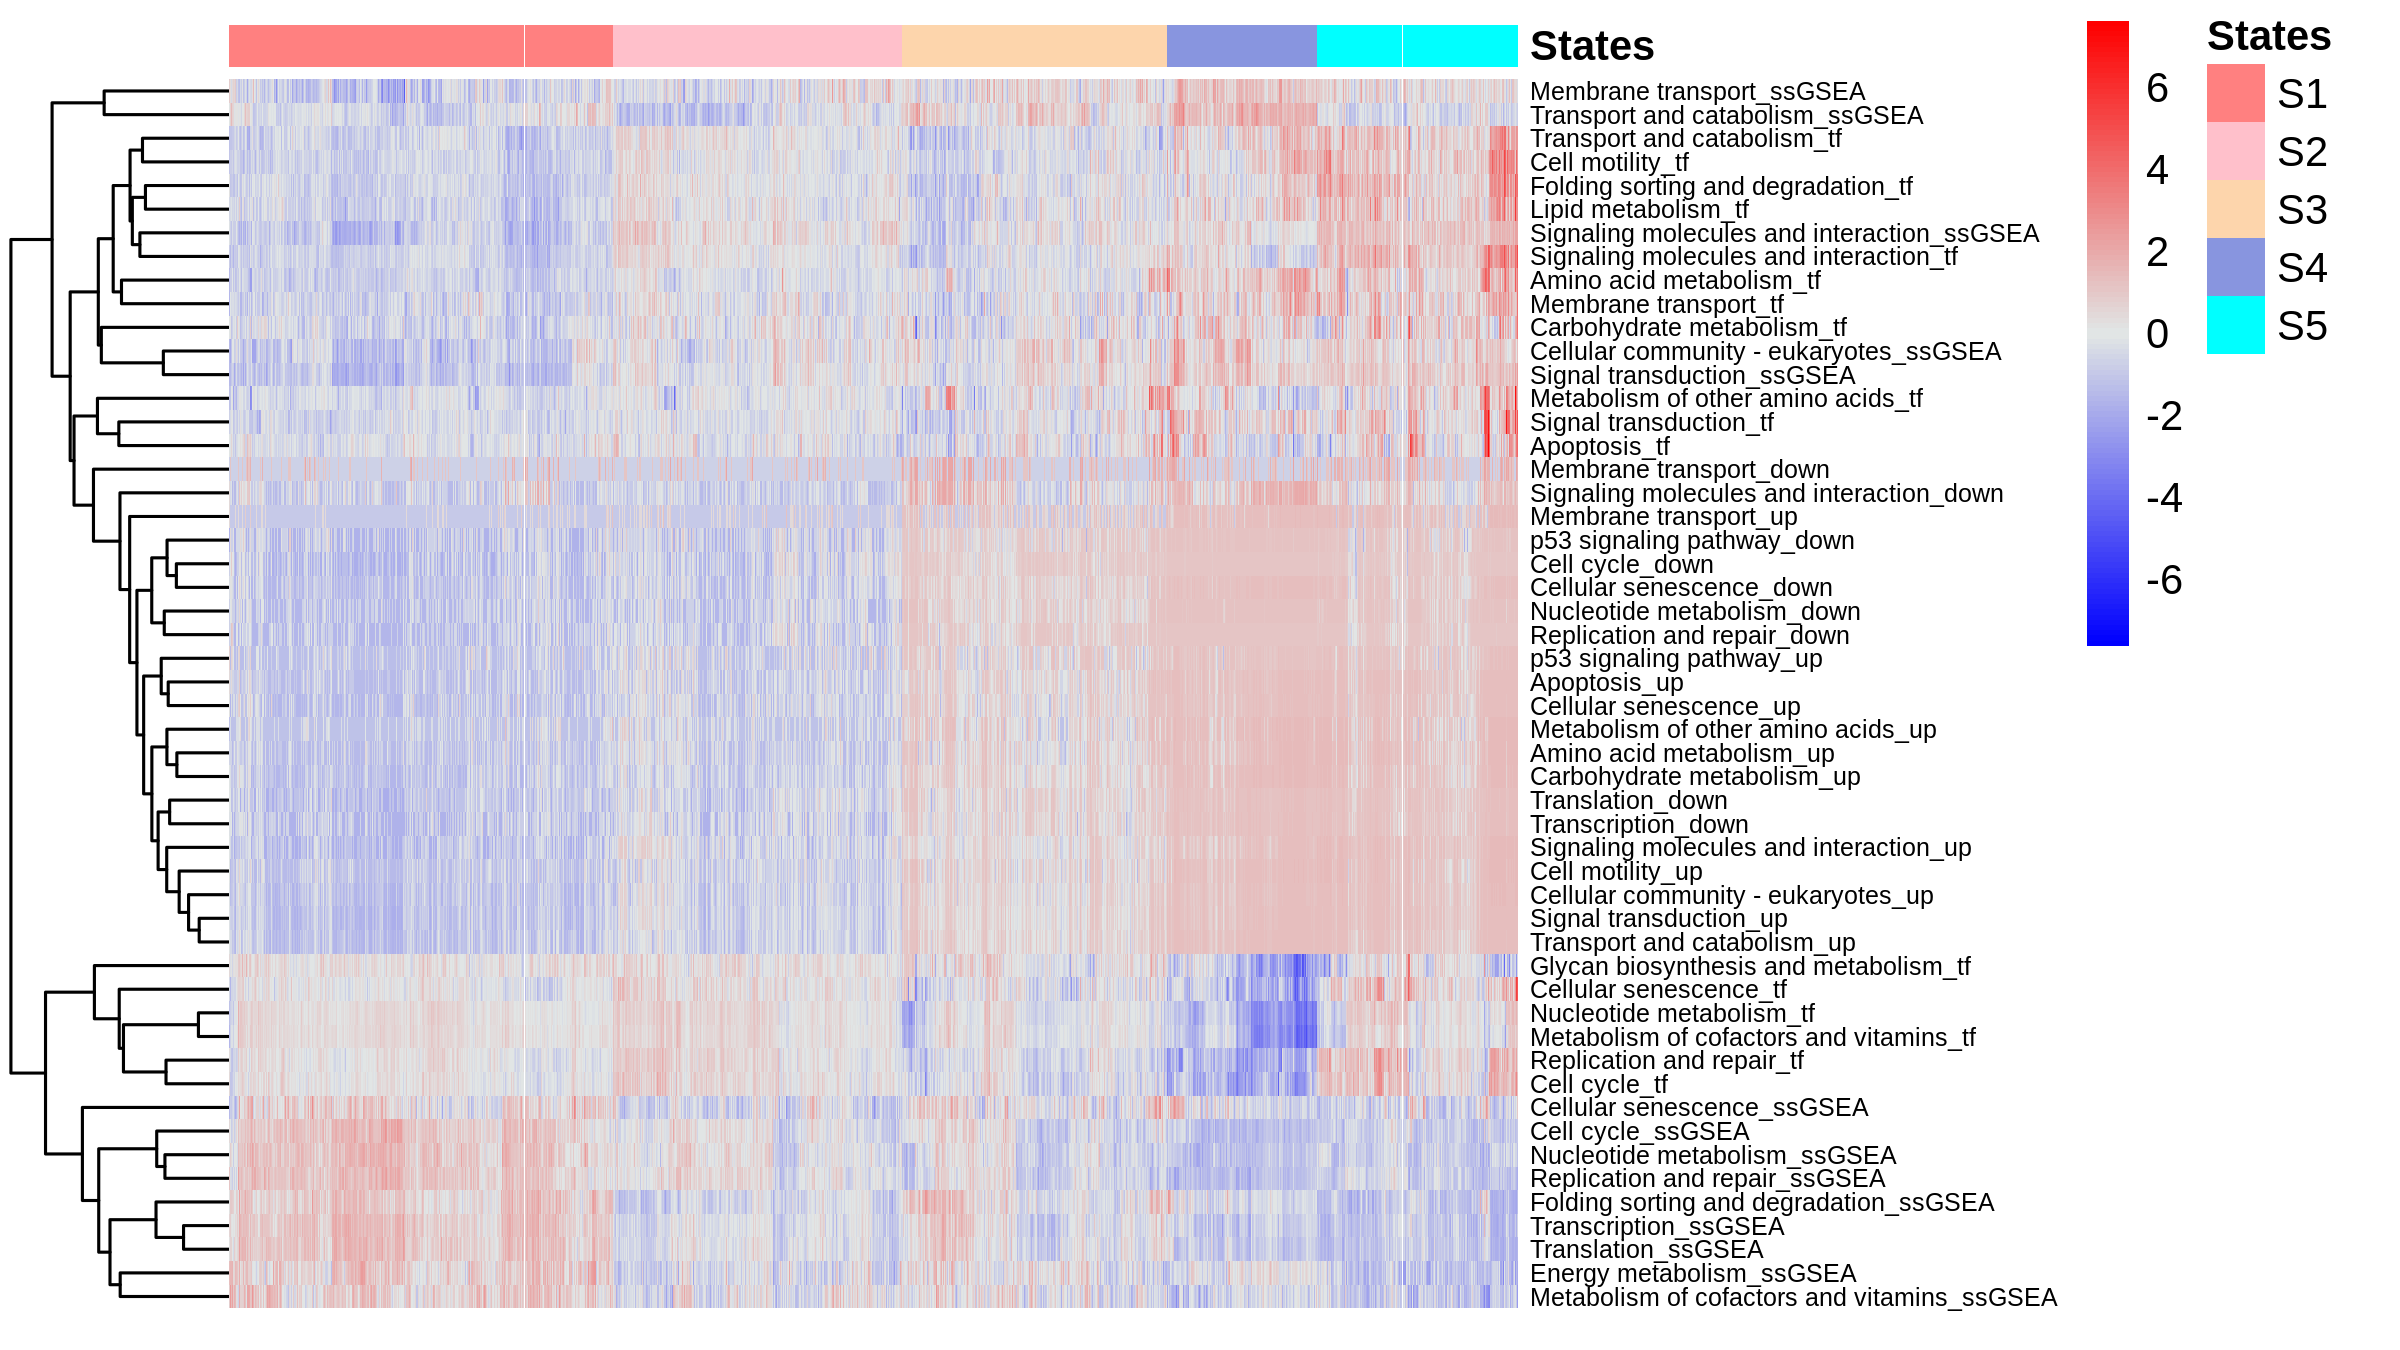

In [21]:
%%R -i Cluster_results,Br,select_modules,cluster_sele,colors,list_labe,out_dir   -w 8 -h 4.5 --units in -r 300
#User specific orders
library(pheatmap)
plot_heatmap <- function(Cluster_results, Br, select_modules,cl_num_sele){

list_labe_R = c()
Rename_Label = c()
color_list = c()

for (i in seq(1,length(list_labe))){
    list_labe_R = append(list_labe_R, list_labe[[i]][1])
    Rename_Label = append(Rename_Label,paste('S',i,sep = ''))
    color_list = append(color_list, colors[[i]][1])
}

names(Rename_Label) = list_labe_R  
names(color_list) = Rename_Label
anno_colors = list(States = color_list)

    
cl_sam = Cluster_results[[cl_num_sele]]$consensusClass
names(cl_sam) = rownames(Br)
annotation_col_1 = data.frame(cl_sam)
Factors = t(Br[,select_modules])
labe = paste('S',annotation_col_1[,1],sep = '')
names(labe) = rownames(annotation_col_1)

annotation_col_1 = c()
names_1 =c()

  

for(i in unique(list_labe_R) ){ 
  if (length(labe[which(labe == i)]) > 2){ 
      result_hclust = hclust(dist((Br[names(labe[which(labe == i)]),])))
      names_1 = c(names_1, names(labe[which(labe == i)])[result_hclust$order])
      annotation_col_1 = c(annotation_col_1, rep(Rename_Label[i],length(labe[which(labe == i)])))
     }
    else{ 
    names_1 = c(names_1, names(labe[which(labe == i)]))
    annotation_col_1 = c(annotation_col_1, rep(Rename_Label[i],length(labe[which(labe == i)])))}
}
annotation_col_1 = data.frame(annotation_col_1)
rownames(annotation_col_1) = names_1
colnames(annotation_col_1) = c('States')


    
write.csv(annotation_col_1, file = paste(out_dir,"/annotation_col.csv",sep = ''))
color_forpheatmap = c(c(colorRampPalette(c("#0000ff", "#e1e5e5"))(60),c(colorRampPalette(c("#e1e5e5","#ff0000"))(60)) ))
    
pheatmap(t(Br[names_1,select_modules]),
         annotation_col = annotation_col_1,
         annotation_colors = anno_colors[1],
         labels_col = '',
         cluster_cols = FALSE,scale = 'row', 
         color = color_forpheatmap,
         fontsize_row = 6
        )
return(annotation_col_1)
}

annotation_col_1 = plot_heatmap(Cluster_results, Br, select_modules,cluster_sele)

#print(annotation_col_1)

In [22]:
matrix_factor_selected = reference_factor_select_modules.loc[:,list(select_modules)]
annotation_col_1 = annotation_col_1 = pd.read_csv(out_dir+"/annotation_col.csv", index_col= 'Unnamed: 0')
#Features = FM_States.Get_features_one_vs_all_others(matrix_factor_selected, 0.01, 0.8, annotation_col_1,select_modules) ##user define threshold

#### Annotation by functional modules

In [31]:
Features, dic_state = FM_States.Get_features_one_vs_one(matrix_factor_selected, 0.01, 1, 3, annotation_col_1,select_modules)

S5
up regulated in : 
Cellular community - eukaryotes,Membrane transport,Signal transduction,Amino acid metabolism,p53 signaling pathway,Carbohydrate metabolism,Cell motility,Apoptosis,Cellular senescence,Signaling molecules and interaction,Metabolism of other amino acids,Transport and catabolism
up regulated in TF: 
Membrane transport,Signal transduction,Amino acid metabolism,Replication and repair,Cell motility,Lipid metabolism,Cellular senescence,Cell cycle,Signaling molecules and interaction,Folding sorting and degradation,Transport and catabolism
down regulated in : 
Energy metabolism,Translation,Replication and repair,Nucleotide metabolism,Transcription,Metabolism of cofactors and vitamins,Cellular senescence,Cell cycle,Folding sorting and degradation


S1
up regulated in : 
Energy metabolism,Translation,Replication and repair,Nucleotide metabolism,Transcription,p53 signaling pathway,Metabolism of cofactors and vitamins,Cellular senescence,Cell cycle,Folding sorting and degradati

#### Heatmap visualization of altered modules

In [24]:
modules = []
for key in dic_state:
    for key1 in dic_state[key]:
        modules = modules + dic_state[key][key1]
modules = list(set(modules))

result = pd.DataFrame()
for state in ["S1","S2","S3","S4","S5"]:
    cur_state = []
    for module in modules:
        if (module in dic_state[state]['up']) and (module not in dic_state[state]['down']):
            cur_state.append(1)
        elif (module  in dic_state[state]['down']) and ( module not in dic_state[state]['up']):
            cur_state.append(-1)
        elif (module  in dic_state[state]['down']) and (module  in dic_state[state]['up']):
            cur_state.append(0.5)
        elif module not in dic_state[state]:
            cur_state.append(0)
    result[state] = cur_state 

result.index = modules
result = result[~(result == 0).all(1)]

/opt/conda/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


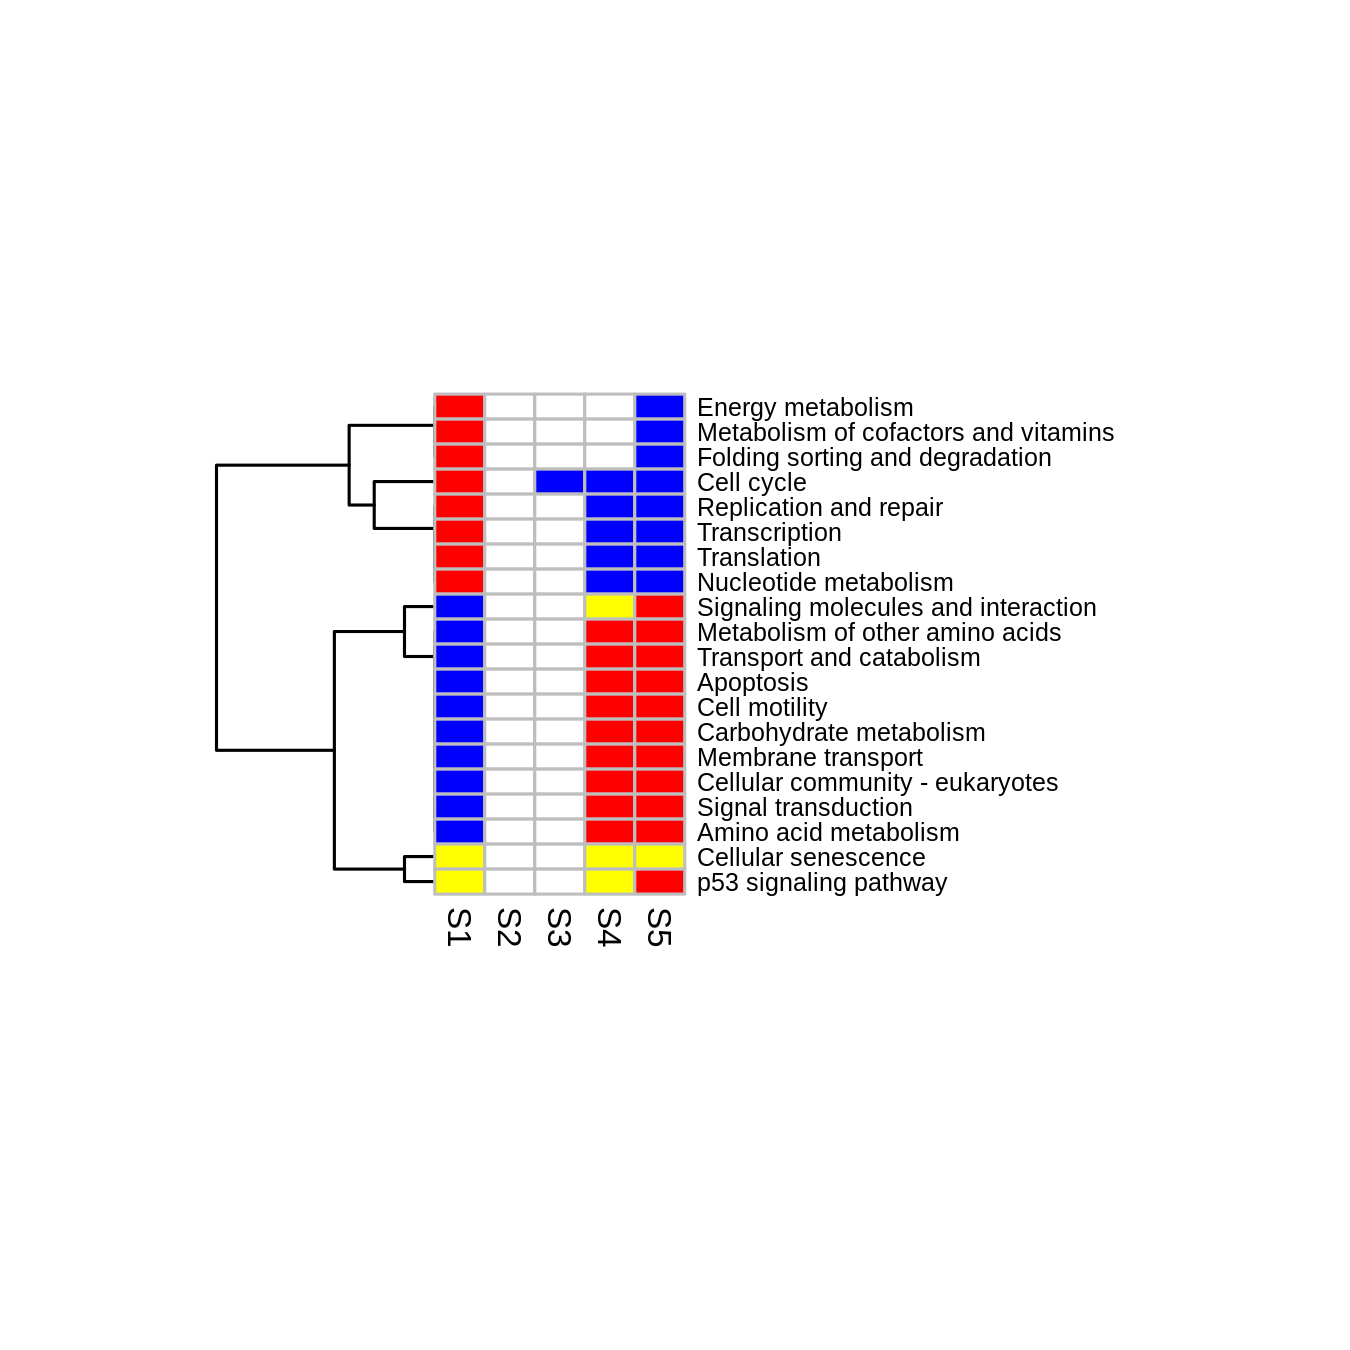

In [25]:
%%R -i result -w 4.5 -h 4.5 --units in -r 300
## Need revision 
n = 5
order = c()
for (i in seq(1,n)){
    order = c(order, (paste('S',i,sep = '')))
}

Features = result
color_max = max(round(min(Features)*100) * -1, round(max(Features)*100))
#color_forpheatmap2 = c(c(colorRampPalette(c("#0000ff", "white"))(color_max)[(color_max - (round(min(Features)*100) * -1)) : color_max],
#                         c(colorRampPalette(c("white","#ff0000"))(color_max)[1:(round(max(Features)*100))]) ))
color_forpheatmap2 = c("blue","white",'yellow','red')
pheatmap((Features),border_color = "grey",
         border_width = 0.05,
         color = color_forpheatmap2,
         cellwidth = 12,
         cellheight = 6,
         cluster_cols = FALSE,
         fontsize_row = 6,
         fontsize_col = 8,
         legend = FALSE)

#### Heatmap visualization of the alteration of transcriptional regulation strength

In [26]:
modules = []
for key in dic_state:
    for key1 in dic_state[key]:
        modules = modules + dic_state[key][key1]
modules = list(set(modules))

result = pd.DataFrame()
for state in ["S1","S2","S3","S4","S5"]:
    cur_state = []
    for module in modules:
        if (module in dic_state[state]['up_tf']) and (module not in dic_state[state]['down_tf']):
            cur_state.append(1)
        elif (module  in dic_state[state]['down_tf']) and ( module not in dic_state[state]['up_tf']):
            cur_state.append(-1)
        elif (module  in dic_state[state]['down_tf']) and (module  in dic_state[state]['up_tf']):
            cur_state.append(0.5)
        elif module not in dic_state[state]:
            cur_state.append(0)
    result[state] = cur_state 

result.index = modules
result = result[~(result == 0).all(1)]

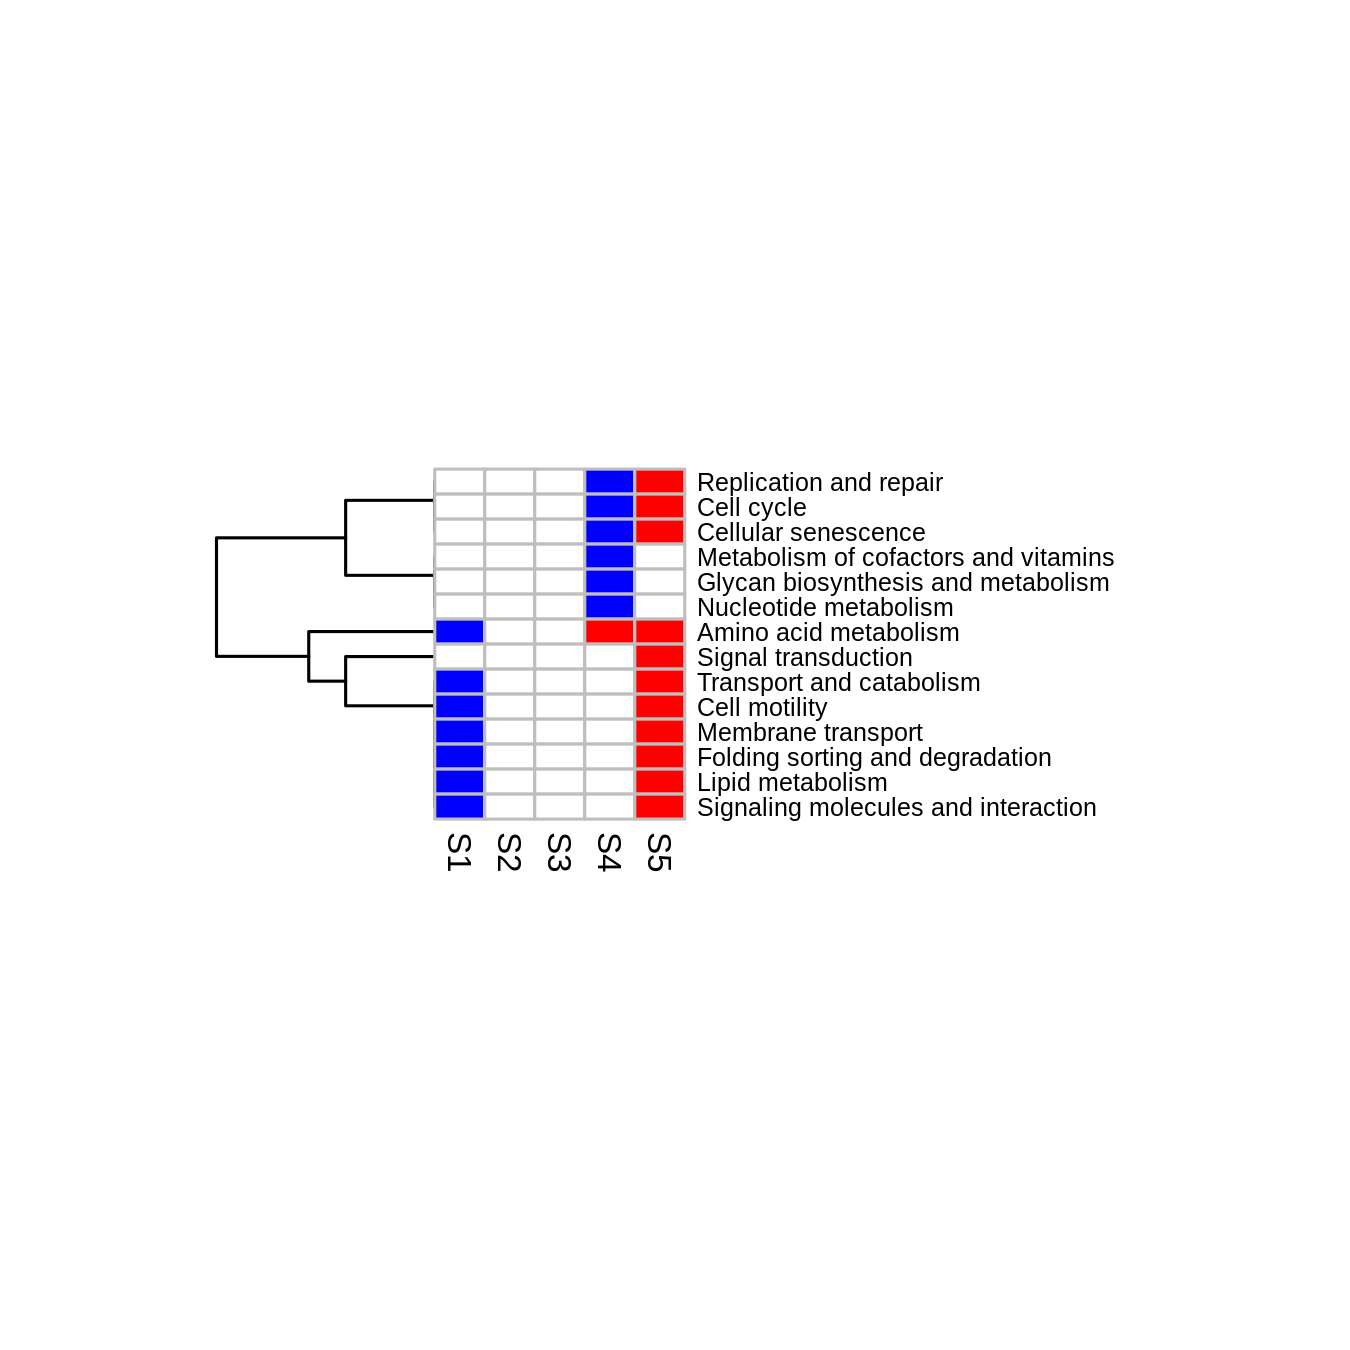

In [27]:
%%R -i result -w 4.5 -h 4.5 --units in -r 300
## Need revision 
n = 5
order = c()
for (i in seq(1,n)){
    order = c(order, (paste('S',i,sep = '')))
}

Features = result
color_max = max(round(min(Features)*100) * -1, round(max(Features)*100))
#color_forpheatmap2 = c(c(colorRampPalette(c("#0000ff", "white"))(color_max)[(color_max - (round(min(Features)*100) * -1)) : color_max],
#                         c(colorRampPalette(c("white","#ff0000"))(color_max)[1:(round(max(Features)*100))]) ))
color_forpheatmap2 = c("blue","white",'yellow','red')
pheatmap((Features),border_color = "grey",
         border_width = 0.05,
         color = color_forpheatmap2,
         cellwidth = 12,
         cellheight = 6,
         cluster_cols = FALSE,
         fontsize_row = 6,
         fontsize_col = 8,
         legend = FALSE)

#### Heatmap visualization of all altered functional-module factors

In [32]:
Features_r = Features.values
nr,nc = Features.shape
samples_name = ro.r.c(Features.index.values)
factor_name = ro.r.c(Features.columns.values)

Features_r = ro.r.matrix(Features_r, nrow=nr, ncol=nc, dimnames = [ Features.index.values, Features.columns.values])

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


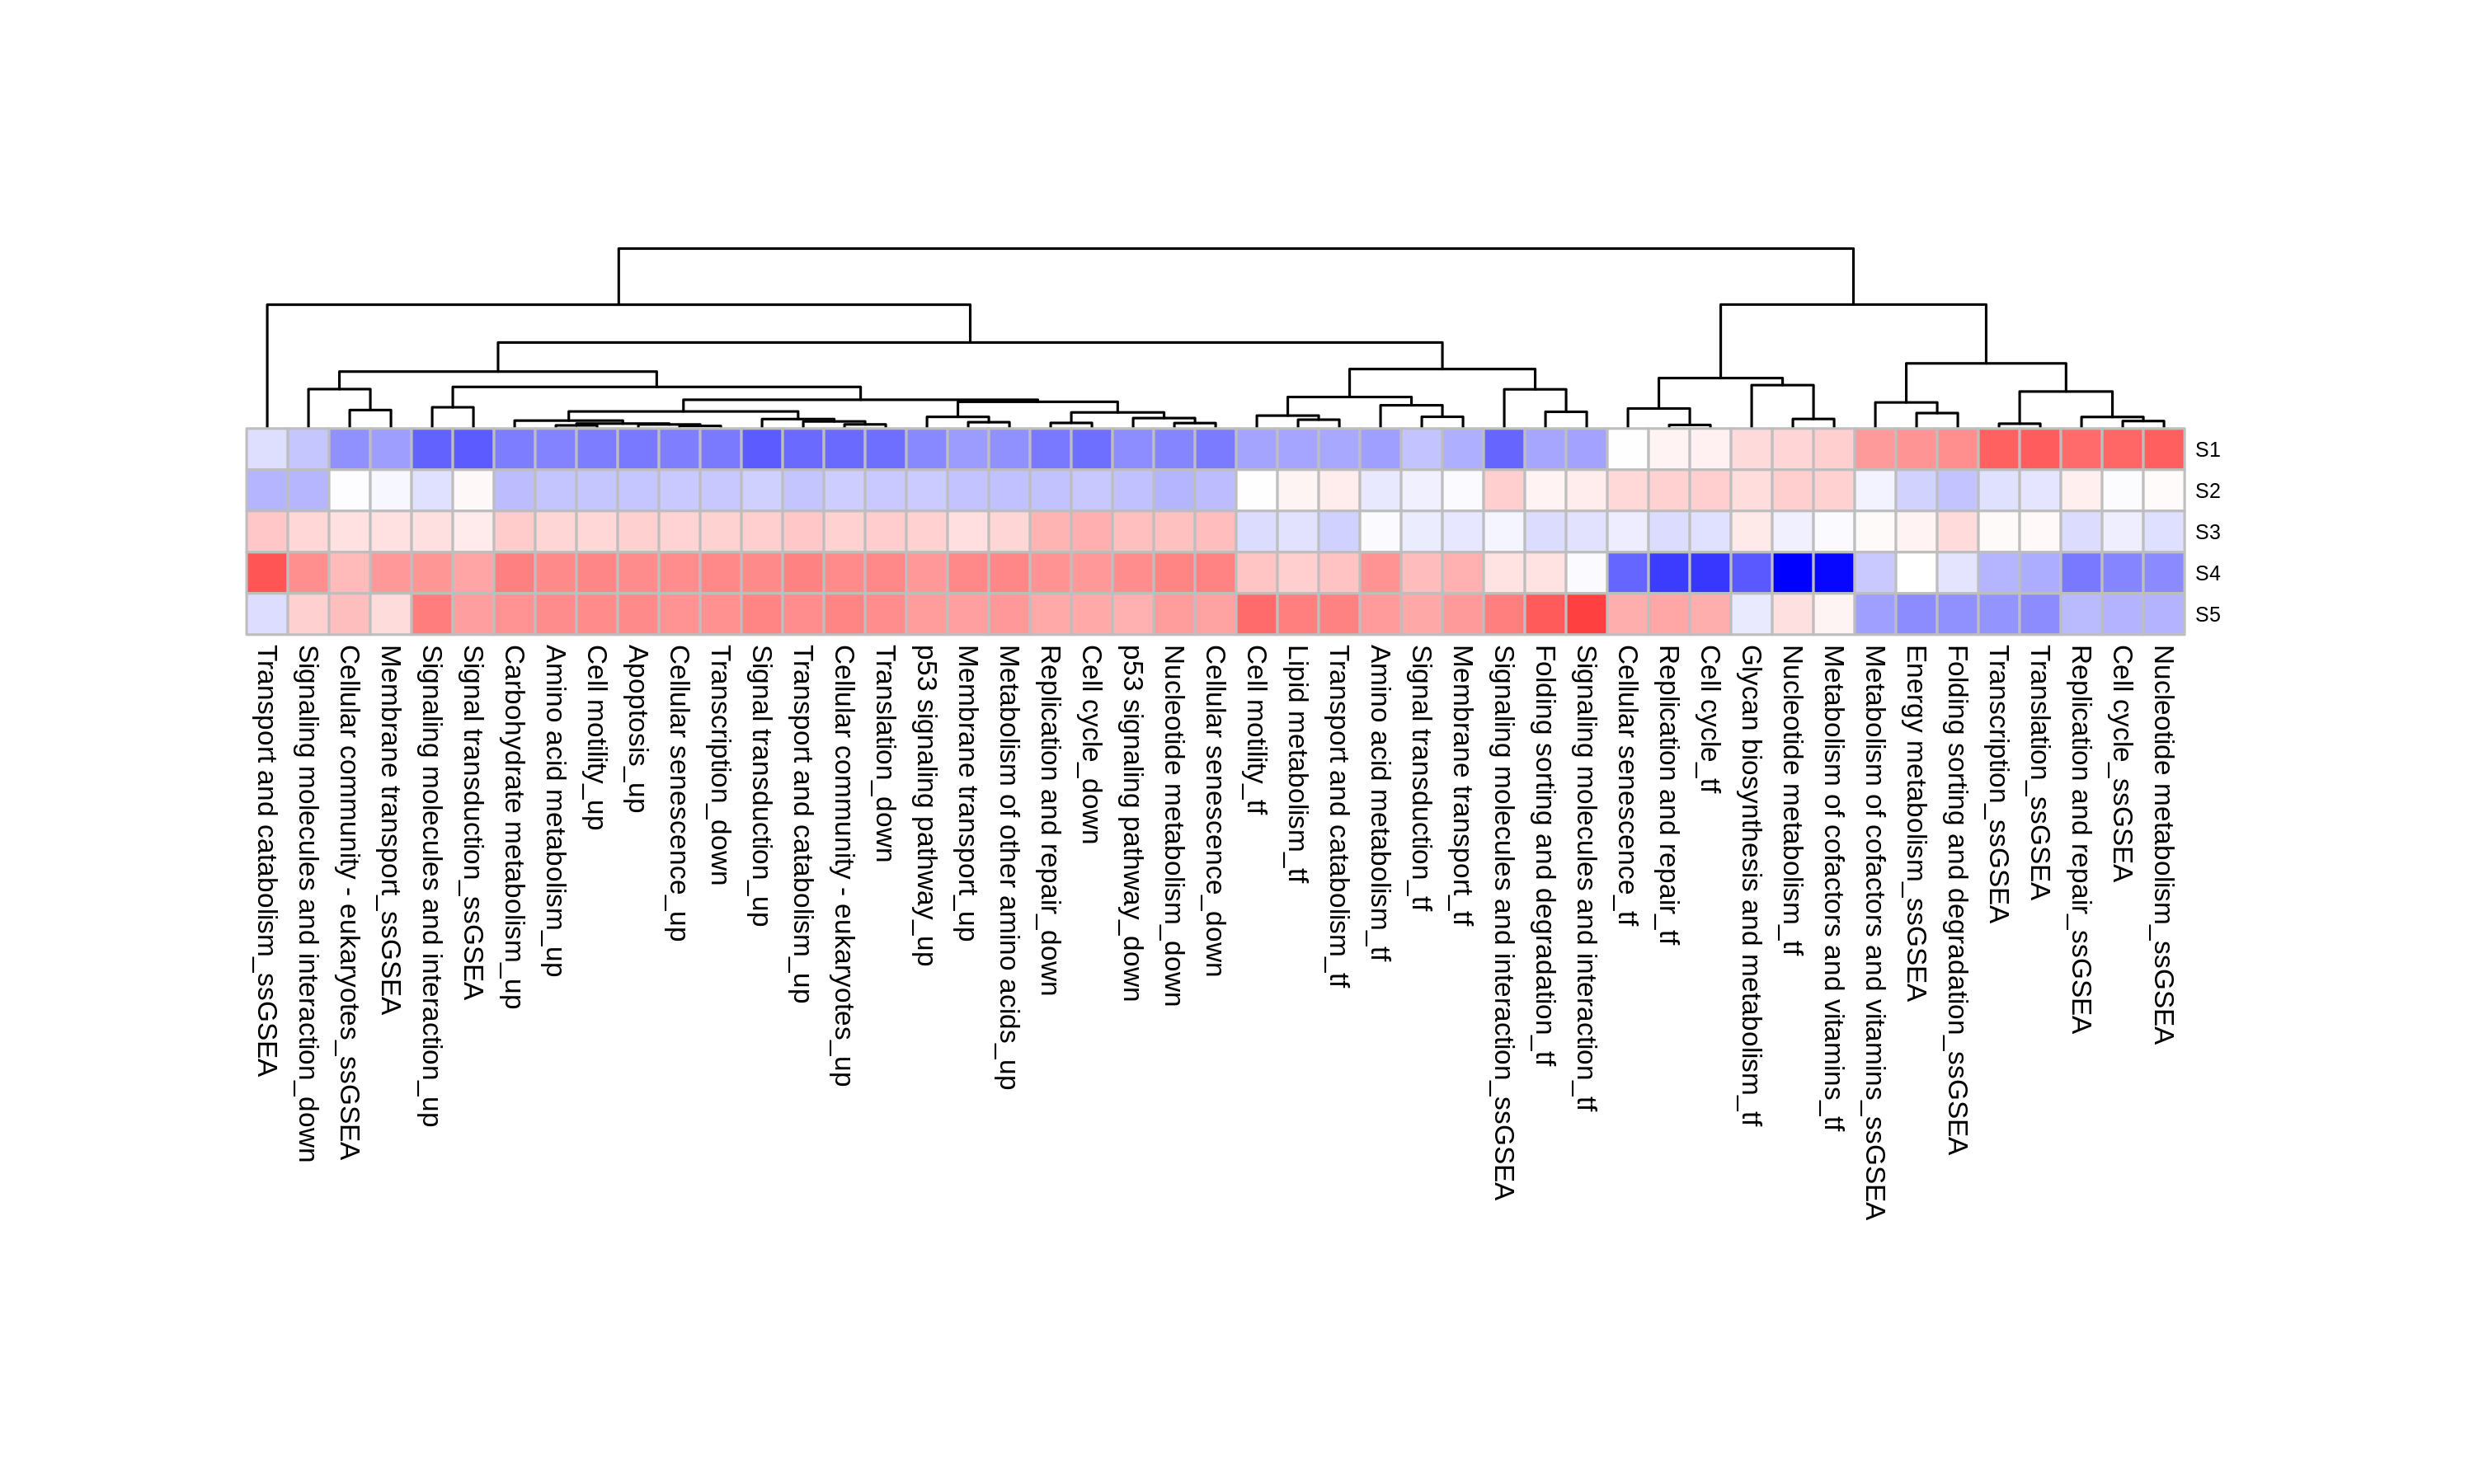

In [33]:
%%R -i Features_r -w 10 -h 6 --units in -r 300
## Need revision 
n = 5
order = c()
for (i in seq(1,n)){
    order = c(order, (paste('S',i,sep = '')))
}

Features = Features_r[order,]
#print(Features)
color_max = max(round(min(Features)*100) * -1, round(max(Features)*100))
color_forpheatmap2 = c(c(colorRampPalette(c("#0000ff", "white"))(color_max)[(color_max - (round(min(Features)*100) * -1)) : color_max],
                         c(colorRampPalette(c("white","#ff0000"))(color_max)[1:(round(max(Features)*100))]) ))

label = Features
label <- data.frame(matrix(as.numeric(unlist(Features)), nrow=length(Features), byrow=T))


pheatmap((Features),border_color = "grey",
         border_width = 0.05,
         color = color_forpheatmap2,
         cellwidth = 12,
         cellheight = 12,
         cluster_cols = TRUE,
         cluster_row = FALSE,
         fontsize_row = 6,
         fontsize_col = 8,
         legend = FALSE)

In [34]:
Features.to_csv(para_in['out_dir']+"/Features.csv")

####  FM-factors that show significant difference between at least one state to the rest states using Wilcoxon rank-sum test (p<0.01 and |Effect size| > 1). There features are selected to predict therapeutic vulnerabilities.

In [35]:
Features = FM_States.Get_features_one_vs_all_others(matrix_factor_selected, 0.01, 1, annotation_col_1,select_modules)
Features.to_csv(para_in['out_dir']+"/Features_diff_all.csv")

S5
up regulated in : 
Signaling molecules and interaction,Membrane transport,Carbohydrate metabolism,Transport and catabolism
up regulated in TF: 
Replication and repair,Cell motility,Lipid metabolism,Cellular senescence,Cell cycle,Signaling molecules and interaction,Folding sorting and degradation,Transport and catabolism
down regulated in : 
Translation,Replication and repair,Nucleotide metabolism,Transcription,Cellular senescence,Cell cycle,Folding sorting and degradation


S1
up regulated in : 
Translation,Replication and repair,Nucleotide metabolism,Transcription,p53 signaling pathway,Cellular senescence,Cell cycle,Folding sorting and degradation
down regulated in : 
Signaling molecules and interaction,Membrane transport,Carbohydrate metabolism,Transport and catabolism
down regulated in TF: 
Cell motility,Lipid metabolism,Signaling molecules and interaction,Folding sorting and degradation,Transport and catabolism


S3
down regulated in : 
Cell cycle


S2


S4
up regulated in : 
Si

#### For more annotation about the transcription factor regulation, drug concentration or drug targets, please check Example1_annotation_tf, Example1_annotation_drugResponse.ipynb and Example1_annotation_targets.